# The main analysis, plus tests

The first half of this notebook details our main analysis in a step-by-step way, with comments and checks. It is later reproduced in `plots.ipynb`, and whatever is in `plots.ipynb` is what is placed in the paper.

The second half goes through many of the sanity checks we did on this analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange
from joblib import delayed, Parallel
from scipy.integrate import cumtrapz
from scipy import stats

from GWMockCat.vt_utils import draw_thetas, interpolate_optimal_snr_grid
from GWMockCat.cosmo_utils import interp_cosmology
from bilby.core.result import read_in_result

from gw_lensing_outliers import dists, rates
from gw_lensing_outliers import transforms as trans
from gw_lensing_outliers import analysis_functions as af

matplotlib.rcParams["contour.negative_linestyle"]="solid"
matplotlib.rcParams["text.usetex"]=True
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['font.size']=12
plt.rcParams.update( {'axes.labelsize':12, 'axes.titlesize':12, 'legend.fontsize':10, 'text.usetex':True} )

color_og_light, color_og_dark = "#8da0cb", "#7570b3"
color_lensing_light, color_lensing_dark =  "#66c2a5", "#1b9e77"
color_alt_light, color_alt_dark = "#fc8d62", "#d95f02"

TEST_LNMU = np.linspace(np.log(0.4),np.log(dists.MU_MAX),num=150)
TEST_MU = np.exp(TEST_LNMU)
TEST_TAU = np.linspace(0,1,num=200)
M1_TEST = np.linspace(1,100,num=100)
Q_TEST = np.linspace(0,1,num=25)
GWMOCKCAT_COSMO_DICT = interp_cosmology(zmax=20)
N_EVS_O3 = 69
N_EVS_O4 = 300
O3_MEASUREMENT_UNCERTAINTY = dict(threshold_snr=8.,snr=1.,mc=0.08,Theta=0.21,eta=0.022) 
O4_MEASUREMENT_UNCERTAINTY = dict(threshold_snr=8.,snr=1.,mc=8e-2,Theta=8e-2,eta=1e-2)
# estimate observing time from data in https://gwosc.org/detector_status/
O4_total_obs_time = np.array([34,42,36])/52 # convert weeks to years, each enrty is a chunk of O4
# percent of time at least 1 LIGO detector was on. 
# This is the sum of the 3-IFO duty cycle, 2-IFO duty cycle, and half of the 1-IFO duty cycle 
# (the 1/2 is assuming that V, L, and H all have similar duty cycles, which is slightly wrong but it shouldn't be a big effect)
O4_duty_cycle = np.array([1-.166,.368+.311+.208/2,.346+.391+.173/2]) 
O4_OBS_TIME = np.sum(O4_total_obs_time * O4_duty_cycle)
O3_total_obs_time = np.array([26,21])/52
O3_duty_cycle = np.array([.445+.374+.150/2,.510+.343+.112/2])
O3_OBS_TIME = np.sum(O3_total_obs_time * O3_duty_cycle)

np_rng = np.random.default_rng(63)


## 1. Determine criteria for outliers
By constructing an un-lensed PPD and calculating the 99th percentile in masses and 1st percentile in distance

In [2]:
# set detector sensitivity
detector = "aligo_O3actual_L1"
osnr, dist_unit = interpolate_optimal_snr_grid(
            f"../data/optimal_snr_{detector}.h5")

# load population data
samples = read_in_result(
    "../data/mixture_ogpriors_except_mmax130_gmax100_result.json"
    ).posterior
# calculate minimum distance and maximum m1 thresholds based on these samples
m1max_thresh, Dmin_thresh = af.create_ppds(np_rng,
                                           samples,
                                           optimal_snr_interpolator=osnr,
                                           distance_unit=dist_unit,
                                           uncert_dict=O3_MEASUREMENT_UNCERTAINTY,
                                           n_evs=N_EVS_O3,
                                           cosmo_dict=GWMOCKCAT_COSMO_DICT)

In [3]:
m1max_thresh

172.1442923571906

## 2. Draw lensed injections

In [4]:
Ninj = int(1e8)
draw_distribution_params = samples.mean()
draw_distribution_params['delta_m'] = 4.95

injections = af.make_injections(np_rng,
                                Ninj,
                                draw_distribution_params,
                                z_bounds=[0.001,dists.ZMAX],
                                mass_bounds=[1,130],
                                mu_bounds=[0.3,dists.MU_MAX],
)


## 3. Calculate if injections are detected + if they were identified as lensed

In [5]:
obs_found_evs, identified_evs = af.find_injections(np_rng,injections,m1max_thresh,Dmin_thresh,osnr,
                                                   dist_unit,O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
mags_identified = identified_evs['magnification']
mags_found = obs_found_evs['magnification']
obs_inferred_redshifts_found = obs_found_evs['inferred_redshift']
true_redshifts_found = obs_found_evs['true_redshift']

18370902 found injections
298500 injections found and identified as outliers


In [6]:
print(f"minimum magnification identified as an outlier: {mags_identified.min():.3f}, maximum magnification identified as an outlier: {mags_identified.max():.1f}, maximum magnification sampled: {dists.MU_MAX}")
print(f"maximum inferred redshift of found sample: {obs_inferred_redshifts_found.max():.2f}, maximum true redshift of found sample: {true_redshifts_found.max():.2f}, maximum true redshift sampled: {dists.ZMAX}") 
# is it a problem we are railing against high mags and high true zs? Check the reweighted populations.

minimum magnification identified as an outlier: 0.959, maximum magnification identified as an outlier: 2500.0, maximum magnification sampled: 2500
maximum inferred redshift of found sample: 1.25, maximum true redshift of found sample: 10.00, maximum true redshift sampled: 10


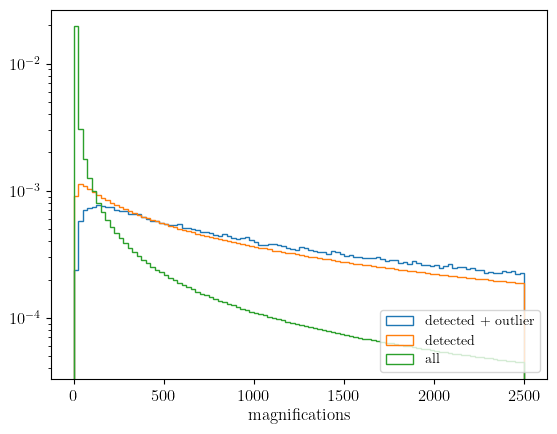

In [7]:
plt.hist(mags_identified,bins=100,density=True,histtype='step',label='detected + outlier')
h,b,_ = plt.hist(mags_found,bins=100,density=True,histtype='step',label='detected')
plt.hist(injections['magnification'],bins=100,density=True,histtype='step',label='all')
plt.yscale('log')

plt.xlabel("magnifications")
plt.legend(loc='lower right')
plt.show()

## 4. Define z-dependent magnification distribution

In [8]:
mu_interp, ln_mu_space, z_space, t_const_space = af.make_Dai_interpolant('../data/Dai_logmag_pdf_t0const_neg0p36_100_grid.h5',
                                                                         make_new=False,
                                                                         return_grids=True)

#### get $\tau$ as a function of lens distribution parameters

100%|██████████| 53/53 [00:00<00:00, 129.25it/s]


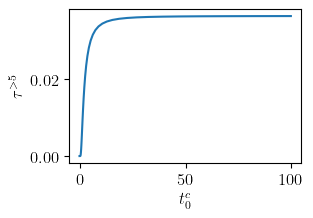

In [11]:
muprime = 5
reference_redshift = 1.
tau_arr = np.zeros_like(t_const_space)
for i in trange(t_const_space.size):
    tau_arr[i] = af.tau_from_t0c(muprime,reference_redshift,t_const_space[i],mu_interp)
plt.figure(figsize=(3,2))
plt.plot(t_const_space, tau_arr)
plt.ylabel('$\\tau^{>5}$')
plt.xlabel('$t_0^c$')
plt.show()


## 5. Use the injections as MC samples in Nexp integrals

In [9]:
Nexp_lensed, Nexp_traditional = af.calc_Nexp(obs_found_evs, identified_evs, mu_interp, t_const=0.00,
                                             rate_evo_index=draw_distribution_params['lamb'],obs_time=O3_OBS_TIME)
Nexp_lensed, Nexp_traditional

(0.0728844909343903, 28.969260814956545)

/Users/amandafarah/miniconda3/envs/lensing/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


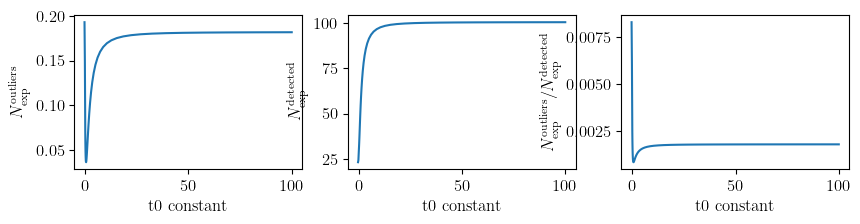

At t0_const=-0.355, Nexp_lensed=1.927e-01, Nexp_traditional=23.30, and f=8.271e-03


In [10]:
def nexp_for_parallel(i):
    return af.calc_Nexp(obs_found_evs, identified_evs, mu_interp, t_const=t_const_space[i], 
                        rate_evo_index=draw_distribution_params['lamb'], obs_time=O3_OBS_TIME)
placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_for_parallel)(i) for i in range(len(t_const_space))))
Nexp_lensed_arr, Nexp_traditional_arr = placeholder[:,0], placeholder[:,1]

labs = ['$N_{\exp}^{\\rm outliers}$','$N^{\\rm detected}_{\exp}$',"$N^{\\rm outliers}_{\exp}/N^{\\rm detected}_{\exp}$"]
arrs = [Nexp_lensed_arr,Nexp_traditional_arr,Nexp_lensed_arr/Nexp_traditional_arr]
f,ax= plt.subplots(1,3,figsize=(10,2),sharex=True)
for i in range(3):
    ax[i].plot(t_const_space,arrs[i])
    ax[i].set_xlabel('t0 constant')
    ax[i].set_ylabel(labs[i])
plt.show()

print(f"At t0_const={t_const_space[0]}, Nexp_lensed={Nexp_lensed_arr[0]:.3e}, Nexp_traditional={Nexp_traditional_arr[0]:.2f}, and f={Nexp_lensed_arr[0]/Nexp_traditional_arr[0]:.3e}")

## Calculate the likelihood of detecting zero outliers as a function of lens distribution parameters

### Plug it in to Binom and Poisson distributions

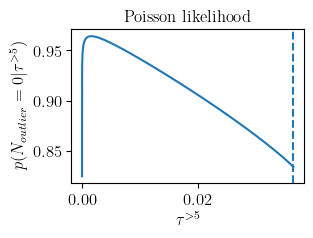

0.03650548247287086


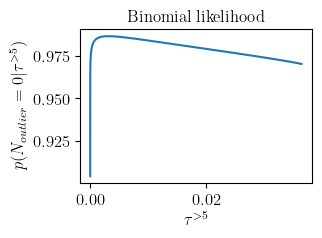

In [28]:
# # in terms of t0c
# plt.figure(figsize=(3,2))
# plt.plot(t_const_space,stats.poisson(Nexp_lensed_arr).pmf(0),label=f"k = {0} outliers")
# cdf = cumtrapz(x=t_const_space,y=stats.poisson(Nexp_lensed_arr).pmf(0), initial=0)
# plt.axvline(t_const_space[np.argmin(np.abs(cdf/cdf[-1]-0.95))],ls='--')
# plt.xlabel('$t_0^c$')
# plt.ylabel('$p(N_{outlier}=0|t_0^c)$')
# plt.title('Poisson likelihood')
# plt.show()

# plt.figure(figsize=(3,2))
# plt.plot(t_const_space,stats.binom(N_EVS,Nexp_lensed_arr/Nexp_traditional_arr).pmf(0),label=f"k = {0} outliers")
# plt.xlabel('$t_0^c$')
# plt.ylabel('$p(N_{outlier}=0|t_0^c,N=69)$')
# plt.title('Binomial likelihood')
# plt.show()

# in terms of tau
plt.figure(figsize=(3,2))
plt.plot(tau_arr,stats.poisson(Nexp_lensed_arr).pmf(0),label=f"k = {0} outliers")
cdf = cumtrapz(x=Nexp_lensed_arr,y=stats.poisson(Nexp_lensed_arr).pmf(0), initial=0)
plt.axvline(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-0.95))],ls='--')
plt.xlabel('$\\tau^{>5}$')
plt.ylabel('$p(N_{outlier}=0|\\tau^{>5})$')
plt.title('Poisson likelihood')
plt.show()

plt.figure(figsize=(3,2))
print(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-0.95))])
plt.plot(tau_arr,stats.binom(N_EVS_O3,Nexp_lensed_arr/Nexp_traditional_arr).pmf(0),label=f"k = {0} outliers")
plt.xlabel('$\\tau^{>5}$')
plt.ylabel('$p(N_{outlier}=0|\\tau^{>5})$')
plt.title('Binomial likelihood')
plt.show()


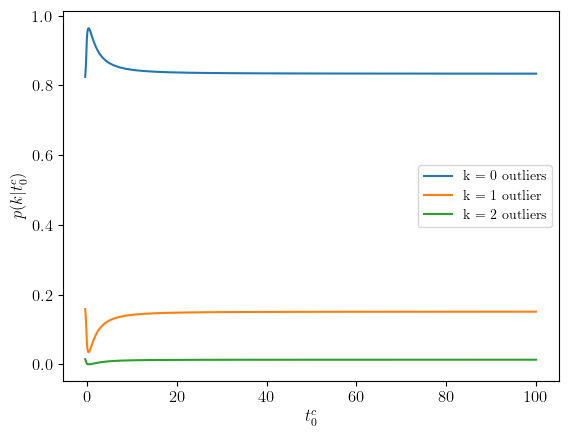

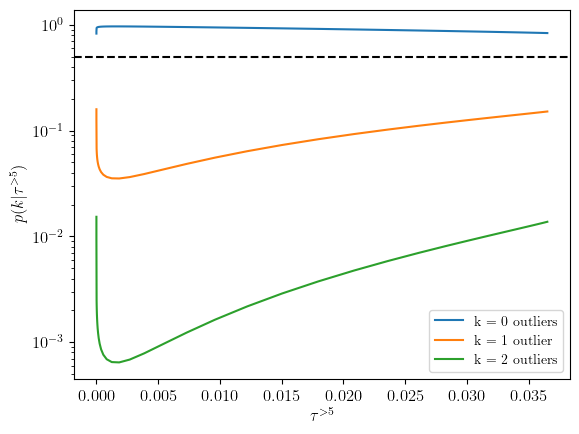

In [30]:
af.plot_likelihood(t_const_space,Nexp_lensed_arr,'$t_0^c$')
plt.show()
af.plot_likelihood(tau_arr,Nexp_lensed_arr,'$\\tau^{>5}$')
plt.yscale('log')
# plt.ylim(1e-5,1.1)
plt.axhline(0.5,ls="--",c='k')
plt.show()

## Single-Outlier case

In [14]:
# some useful helper functions
def z_t(m1z_obs, mmax_pop):
    return m1z_obs/mmax_pop - 1 
def min_mu(m1z_obs, dL_obs, mmax_pop):
    zt = z_t(m1z_obs,mmax_pop)
    dL_t = trans.dL_approx(zt)
    return (dL_t/dL_obs)**2

### Injection study

In [15]:
# Which tau would give us an outlier after O4?
## calc Nexp for O4
osnr_O4, dist_unit = interpolate_optimal_snr_grid(
            "../data/optimal_snr_aligo_O4low.h5")
samples_in_sigmas = (samples-samples.mean())/samples.std()
new_sigma = samples.std() * np.sqrt(N_EVS_O3/N_EVS_O4)
rescaled_samples = samples.mean() + samples_in_sigmas*new_sigma
rescaled_samples['gaussian_mass_maximum'] = samples['gaussian_mass_maximum']
rescaled_samples['amax'] = samples['amax']
m1max_thresh_O4, Dmin_thresh_O4 = af.create_ppds(np_rng,
                                           rescaled_samples,
                                           optimal_snr_interpolator=osnr_O4,
                                           distance_unit=dist_unit,
                                           uncert_dict=O4_MEASUREMENT_UNCERTAINTY,
                                           n_evs=N_EVS_O4,
                                           cosmo_dict=GWMOCKCAT_COSMO_DICT)

# m1max_thresh_O4 is lower than the O3 one! So decreases in hyperparam uncert overcome more chances at large masses
print("O4 mass outlier threshold: ", m1max_thresh_O4)
obs_found_evs_O4, identified_evs_O4 = af.find_injections(np_rng,injections,m1max_thresh_O4,Dmin_thresh_O4,osnr_O4,
                                                         dist_unit,O4_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)

def nexp_for_parallel_O4(i):
    return af.calc_Nexp(obs_found_evs_O4, identified_evs_O4, mu_interp, t_const=t_const_space[i], 
                        rate_evo_index=draw_distribution_params['lamb'],obs_time=O4_OBS_TIME)
placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_for_parallel_O4)(i) for i in range(len(t_const_space))))
Nexp_lensed_arr_O4, Nexp_traditional_arr_O4 = placeholder[:,0], placeholder[:,1]

## find Nexp sufficiently close to 1
injection_index = np.argwhere(Nexp_lensed_arr_O4>0.67).min()
## get the tau associated with that Nexp
real_tau, real_t0c = tau_arr[injection_index], t_const_space[injection_index]  
print(real_tau)


O4 mass outlier threshold:  136.6177938985444
22633055 found injections
734974 injections found and identified as outliers
0.026083604988028752


In [23]:
# get the outlier with the highest probability given that tau (and mass and z dist, etc.)
p_mu_identified = mu_interp((np.log(identified_evs_O4['magnification']),
                             obs_found_evs_O4['true_redshift'][identified_evs_O4['identified_bool']],
                             real_t0c)
                            )
weights = p_mu_identified/obs_found_evs_O4['lnmu_pdraw'][identified_evs_O4['identified_bool']] # weights too small here?
outlier_idx = np.random.choice(len(identified_evs_O4['magnification']),p=weights/np.sum(weights))
outlier_maxl = {key: identified_evs_O4[key][outlier_idx] for key in identified_evs_O4.keys() if 'bool' not in key}
print("true src mass: ", injections['true_src_mass'][obs_found_evs_O4['found_bool']][identified_evs_O4['identified_bool']][outlier_idx])
outlier_maxl
# do the below for it

# do we recover the same tau?

true src mass:  79.49437559362332


{'det_mass': 263.86058939796874,
 'inferred_src_mass': 160.65141102370313,
 'magnification': 15.110986361078407,
 'mass_ratio': 0.5450908227529037,
 'inferred_redshift': 0.6424417794813999,
 'inferred_distance': 3.9548765669644492,
 'snr': 10.943001126873249,
 'Theta': 0.5530359855770823}

In [24]:
# # choose an outlier from above. Try one with a relatively small mag
min_ided_mag_idx = np.argwhere(identified_evs['magnification']<20)[10][0]
outlier_maxl = {key: identified_evs[key][min_ided_mag_idx] for key in identified_evs.keys() if 'bool' not in key}
m1z = outlier_maxl['det_mass']
dL_l = outlier_maxl['inferred_distance']
min_mu_outlier = min_mu(m1z,dL_l,m1max_thresh_O4)
min_mu_outlier#,outlier_maxl['magnification']

2.481558467378775

Probability of getting an event with mu>=2.5: 0.00014797788491912068


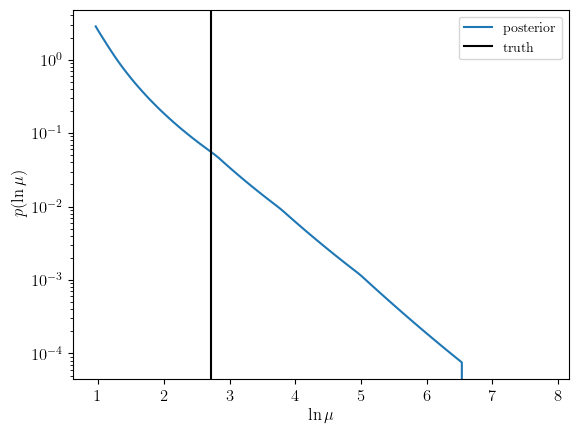

The probability of getting an event with mu>=2.5 given the detected distribution of magnifications is 0.00120


In [25]:
# calculate population-informed posterior for the event
above_min_mu = TEST_LNMU[TEST_LNMU>=np.log(min_mu_outlier)]
try:
    p_mu_given_dlt = mu_interp((above_min_mu,trans.z_at_dl_approx(dL_l*np.sqrt(np.exp(above_min_mu))),0.)) 
except ValueError:
    p_mu_given_dlt = np.zeros_like(above_min_mu)
    for i in range(len(above_min_mu)):
        z = trans.z_at_dl_approx(dL_l*np.sqrt(np.exp(above_min_mu[i])))
        if z>10:
            p_mu_given_dlt[i] = 0
        else:
            p_mu_given_dlt[i] = mu_interp((above_min_mu[i],z,0.)) 
prob = np.trapz(y=p_mu_given_dlt,x=above_min_mu)
print(f"Probability of getting an event with mu>={min_mu_outlier:.1f}: {prob}")
p_mu_given_dlt /= prob
plt.plot(above_min_mu,p_mu_given_dlt,label='posterior')
plt.axvline(np.log(outlier_maxl['magnification']),c='k',label='truth')
plt.xlabel('$\ln\mu$')
plt.ylabel("$p(\ln\mu)$")
plt.yscale('log')
plt.legend()
plt.show()
# What was the probability of observing this magnification given the event was detected adn the fiducial mu dist?
# this is fraction of found injections with mu>min_mu_outlier. 
weights_det = mu_interp((np.log(obs_found_evs_O4['magnification']),obs_found_evs_O4['true_redshift'],0.)) /obs_found_evs_O4['lnmu_pdraw']
p_mu_given_det = np.sum(weights_det[obs_found_evs_O4['magnification']>=min_mu_outlier])/weights_det.sum()
print(f"The probability of getting an event with mu>={min_mu_outlier:.1f} given the detected distribution of magnifications is {p_mu_given_det:.5f}")


In [19]:
# homog poisson on tau
mag_bool = obs_found_evs_O4['magnification'] > min_mu_outlier
obs_found_gtr_mumin = {key:obs_found_evs_O4[key][mag_bool] for key in ['det_mass', 'inferred_src_mass', 'mass_ratio', 'inferred_redshift', 'inferred_distance', 'true_redshift', 'magnification', 'lnmu_pdraw']}
obs_found_gtr_mumin['identified_bool'] = mag_bool
def nexp_for_parallel_mumin(i):
    return af.calc_Nexp(obs_found_evs_O4, obs_found_gtr_mumin, mu_interp, t_const=t_const_space[i],
                        rate_evo_index=draw_distribution_params['lamb'],obs_time=O4_OBS_TIME)
placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_for_parallel_mumin)(i) for i in range(len(t_const_space))))
Nexp_gtr_mumin, Nexp_traditional_arr = placeholder[:,0], placeholder[:,1]

4.8223388715079455e-05
0.00026087952856702207
0.0008330081189376808


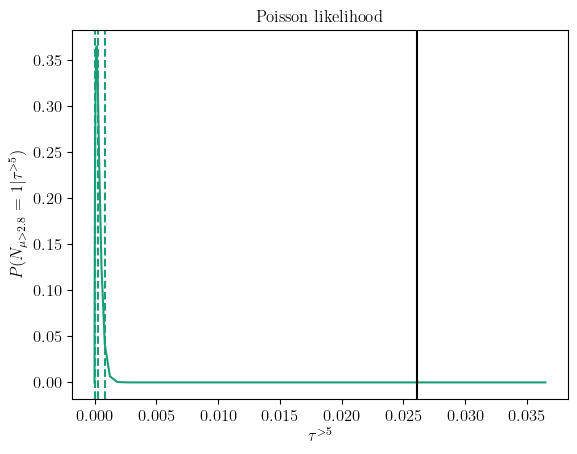

0.0008330081189376808
0.00026087952856702207


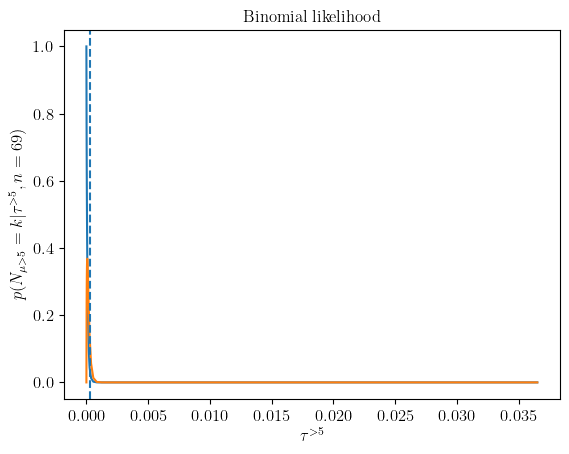

In [26]:
# plt.plot(tau_arr,stats.poisson(Nexp_gtr_mumin).pmf(0),label=f"k = {0} outliers")
plt.plot(tau_arr,stats.poisson(Nexp_gtr_mumin).pmf(1),color=color_lensing_dark,)
# cdf = cumtrapz(x=Nexp_gtr_mumin,y=stats.poisson(Nexp_gtr_mumin).pmf(0), initial=0)
# plt.axvline(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-0.95))],ls='--')
cdf = cumtrapz(x=Nexp_gtr_mumin,y=stats.poisson(Nexp_gtr_mumin).pmf(1), initial=0)
for p in [0.05,0.5,0.95]:
    plt.axvline(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-p))],color=color_lensing_dark,ls='--')
    print(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-p))])
plt.xlabel('$\\tau^{>5}$')
plt.ylabel('$P(N_{\mu>2.8}=1|\\tau^{>5})$')
plt.title('Poisson likelihood')
# plt.xlim(-0.0001,0.008)
plt.axvline(real_tau,color='k')
plt.show()
print(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-0.95))])

plt.plot(tau_arr,stats.binom(N_EVS_O4,Nexp_gtr_mumin/Nexp_traditional_arr).pmf(0),label=f"k = {0} outliers")
plt.plot(tau_arr,stats.binom(N_EVS_O4,Nexp_gtr_mumin/Nexp_traditional_arr).pmf(1),label=f"k = {1} outlier")
cdf = cumtrapz(x=Nexp_gtr_mumin,y=stats.binom(N_EVS_O4,Nexp_gtr_mumin/Nexp_traditional_arr).pmf(0), initial=0)
plt.axvline(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-0.95))],ls='--')
plt.xlabel('$\\tau^{>5}$')
plt.ylabel('$p(N_{\mu>5}=k|\\tau^{>5},n=69)$')
plt.title('Binomial likelihood')
print(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-0.95))])
plt.show()
# WHY IS USING THE ACTUAL MU BROADER THAN USING MUMIN? SHOULD I BE USING A NARROW RANGE AROUND MU_TRUE?

In [19]:
0.00037886868494300713 - 7.541174468386235e-05

0.00030345694025914476

In [20]:
# inhomog poisson on tau
from GWMockCat import posterior_utils

Nexp = Nexp_gtr_mumin
R0 = 15
## get PE samples for the event
n_PE_samps = int(7e3)

smc = O3_MEASUREMENT_UNCERTAINTY['threshold_snr']/outlier_maxl['snr'] * O3_MEASUREMENT_UNCERTAINTY['mc']
mcdet = posterior_utils.mchirp(outlier_maxl['det_mass'], outlier_maxl['det_mass']*outlier_maxl['mass_ratio'])
seta = O3_MEASUREMENT_UNCERTAINTY['threshold_snr']/outlier_maxl['snr'] * O3_MEASUREMENT_UNCERTAINTY['eta']
eta = posterior_utils.etafunc(outlier_maxl['det_mass'], outlier_maxl['det_mass']*outlier_maxl['mass_ratio'])
st = O3_MEASUREMENT_UNCERTAINTY['threshold_snr']/outlier_maxl['snr'] * O3_MEASUREMENT_UNCERTAINTY['Theta']
Theta = outlier_maxl['Theta']

mc_samps = np_rng.lognormal(mean=np.log(mcdet),sigma=smc,size=n_PE_samps)
eta_samps = stats.truncnorm((0.0-eta)/seta,(0.25-eta)/seta,
                                  loc=eta,
                                  scale=seta
                                  ).rvs(size=n_PE_samps,random_state=np_rng)
theta_samps = stats.truncnorm((0.0-Theta)/st, (1.0-Theta)/st,
                                    loc=Theta,scale=st
                                   ).rvs(size=n_PE_samps,random_state=np_rng)
rho_samps = stats.truncnorm((0.0-outlier_maxl['snr'])/O3_MEASUREMENT_UNCERTAINTY['snr'], np.inf,
                                  loc=outlier_maxl['snr'],scale=O3_MEASUREMENT_UNCERTAINTY['snr']
                                 ).rvs(size=n_PE_samps,random_state=np_rng)

m1det_samps, m2det_samps = posterior_utils.m1m2_from_mceta(mc_samps,eta_samps)
inferred_dl_samps = theta_samps * osnr(m1det_samps,m2det_samps,grid=False)/rho_samps
inferred_z_samps = trans.z_at_dl_approx(inferred_dl_samps)
inferred_m1s_samps = m1det_samps/(1+inferred_z_samps)
q_samps = m2det_samps/m1det_samps

mu_samps = np_rng.uniform(low=min_mu_outlier,high=500,size=n_PE_samps) # TODO: increase upper limit, but to do that we need to increase the maximum redshift allowed in mu_interp
ln_mu_samps = np.log(mu_samps)

true_dl_samps = inferred_dl_samps * np.sqrt(mu_samps)
true_z_samps = trans.z_at_dl_approx(true_dl_samps)
true_z_samps= np.where(true_z_samps>10,9.9999,true_z_samps) #TODO: remove the where statement, after increaseing maximum redshift allowed in mu_interp
true_m1s_samps = m1det_samps/(1+true_z_samps)

# transform prior to be represented in terms of src frame m1, q and z
jacobian = mc_samps / posterior_utils.dm1m2_dMceta(m1det_samps,m2det_samps) * m1det_samps \
        / (posterior_utils.ddL_drho(osnr,m1det_samps,m2det_samps,rho_samps,theta_samps)*rho_samps**2/(inferred_dl_samps**2)) \
        * (1 + inferred_z_samps) / trans.dDLdz_approx(inferred_z_samps)
pe_prior = 1/(0.25*mc_samps.max()*rho_samps.max()*theta_samps.max()) * jacobian * 1e6


## calc average pop prob as a function of t0c
p_m1_q_z = dists.threeDpopulation(true_m1s_samps,q_samps,true_z_samps,
                                    m1_kwargs=draw_distribution_params[af.MASS_KEYS],
                                    q_beta=draw_distribution_params['beta'],
                                    z_alpha=draw_distribution_params['lamb'],
                                    normalize=True)
bracket_term = np.zeros(len(t_const_space))
for i in trange(len(t_const_space)):
    p_lnmu = mu_interp((ln_mu_samps,true_z_samps,t_const_space[i]))
    bracket_term[i] = np.mean(p_m1_q_z * p_lnmu / pe_prior * mu_samps) # mu is the jacobian to go from a flat-in-mu pe prior to a pop posterior in logmu

## plot the HBA likelihood
pdf = np.exp(-1*Nexp)*R0*bracket_term
cdf = cumtrapz(x=Nexp,y=pdf, initial=0)
for p in [0.05,0.5,0.95]:
    plt.axvline(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-p))],ls='--')
plt.plot(tau_arr,pdf)
plt.xlabel('$\\tau^{>5}$')
plt.ylabel('$p(N_{\mu>2.6}=k|\\tau^{>5})$')
plt.title('Inhomogenous Poisson likelihood')
plt.xlim(-0.0001,0.01)
plt.show()
print(tau_arr[np.argmin(np.abs(cdf/cdf[-1]-0.95))])


KeyError: 'snr'

## Tests

### Effects of mmax threshold on tau constraint

$m_1^{thresh}=$30
For zero outliers, the 95th percentile of p(tau) is 0.020851955746988695
For one outlier, the 5th percentile of p(tau) is 1.2442743896619886e-47
$m_1^{thresh}=$100
For zero outliers, the 95th percentile of p(tau) is 0.017959212517195497
For one outlier, the 5th percentile of p(tau) is 1.4492708214070238e-05
$m_1^{thresh}=$178.83353605702996
For zero outliers, the 95th percentile of p(tau) is 0.03509030097110671
For one outlier, the 5th percentile of p(tau) is 0.009597349974868228
$m_1^{thresh}=$250
For zero outliers, the 95th percentile of p(tau) is 0.035497093627686147
For one outlier, the 5th percentile of p(tau) is 0.009597349974868228
$m_1^{thresh}=$300
For zero outliers, the 95th percentile of p(tau) is 0.035497093627686147
For one outlier, the 5th percentile of p(tau) is 0.009597349974868228


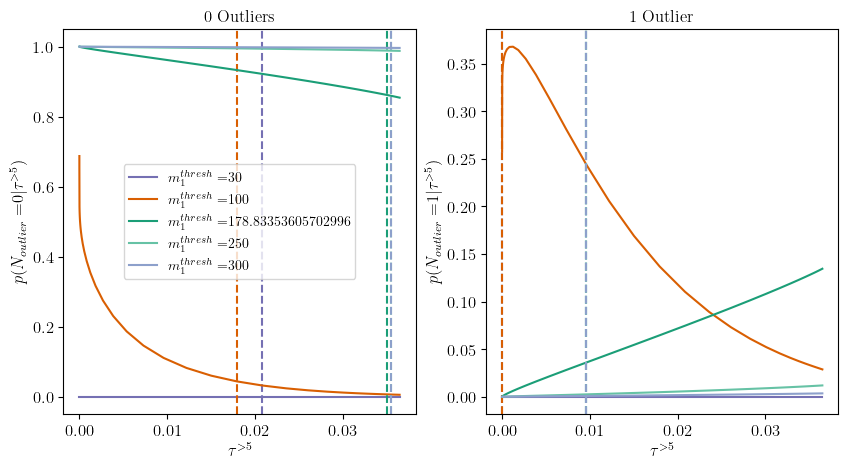

In [23]:
# percentile=95
# m1_max = [30, 100, m1max_thresh, 250, 300]
# detectors = ['$m_1^{thresh}=$'+str(m) for m in m1_max]

# observing_time = 1 # in years
# colors = [color_og_dark, color_alt_dark, color_lensing_dark, color_lensing_light, color_og_light]
# # save the magnifications for each detector to use in Fig 5.
# detected_bools = dict()
# identified_bools = dict()

# save the Nexp arrays just in case
# Nexp_lensed = np.zeros((len(detectors),len(t_const_space)))
# Nexp_traditional = np.zeros_like(Nexp_lensed)

f, ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=False)

for i in range(len(detectors)):
    print(detectors[i])
    
    # obs_found_evs, identified_evs = af.find_injections(np_rng,injections,m1_max[i],Dmin_thresh,osnr,dist_unit,O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
    # detected_bools[detectors[i]], identified_bools[detectors[i]] = obs_found_evs['found_bool'], identified_evs['identified_bool']
    # # calculate the expected number of outliers and detections as a function of t0c
    # def nexp_for_parallel(i):
    #     return af.calc_Nexp(obs_found_evs, identified_evs, mu_interp, t_const=t_const_space[i], rate_evo_index=draw_distribution_params['lamb'])
    
    # placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_for_parallel)(j) for j in range(len(t_const_space))))
    # Nexp_lensed[i], Nexp_traditional[i] = placeholder[:,0]*observing_time, placeholder[:,1]*observing_time

    # plug Nexp into the poisson likelihood, but plot it as a function of tau
    cdf = cumtrapz(x=Nexp_lensed[i],y=stats.poisson(Nexp_lensed[i]).pmf(0), initial=0)
    ax[0].plot(tau_arr,stats.poisson(Nexp_lensed[i]).pmf(0), color=colors[i], label=detectors[i])
    percentile_idx = np.argmin(np.abs(cdf/cdf[-1]-percentile/100))
    ax[0].axvline(tau_arr[percentile_idx],ls='--',color=colors[i])
    print(f"For zero outliers, the {percentile}th percentile of p(tau) is {tau_arr[percentile_idx]}")
    
    cdf = cumtrapz(x=Nexp_lensed[i],y=stats.poisson(Nexp_lensed[i]).pmf(1), initial=0)
    ax[1].plot(tau_arr,stats.poisson(Nexp_lensed[i]).pmf(1), color=colors[i], label=detectors[i])
    percentile_idx = np.argmin(np.abs(cdf/cdf[-1]-(1-percentile/100)))
    ax[1].axvline(tau_arr[percentile_idx],ls='--',color=colors[i])
    print(f"For one outlier, the {100-percentile}th percentile of p(tau) is {tau_arr[percentile_idx]}")

ax[0].legend()
for i in range(2):
    ax[i].set_xlabel('$\\tau^{>5}$')
    ax[i].set_ylabel('$p(N_{outlier}=$'+f'{i}'+'$|\\tau^{>5})$')
ax[0].set_title(f"0 Outliers")
ax[1].set_title(f"1 Outlier")
plt.show()

### Effect of `OUTLIER_THRESH`

In [29]:
t_const_space

array([-3.55000000e-01, -1.77500000e-01,  0.00000000e+00,  1.00000000e-02,
        1.20679264e-02,  1.45634848e-02,  1.75751062e-02,  2.12095089e-02,
        2.55954792e-02,  3.08884360e-02,  3.72759372e-02,  4.49843267e-02,
        5.42867544e-02,  6.55128557e-02,  7.90604321e-02,  9.54095476e-02,
        1.15139540e-01,  1.38949549e-01,  1.67683294e-01,  2.02358965e-01,
        2.44205309e-01,  2.94705170e-01,  3.55648031e-01,  4.29193426e-01,
        5.17947468e-01,  6.25055193e-01,  7.54312006e-01,  9.10298178e-01,
        1.09854114e+00,  1.32571137e+00,  1.59985872e+00,  1.93069773e+00,
        2.32995181e+00,  2.81176870e+00,  3.39322177e+00,  4.09491506e+00,
        4.94171336e+00,  5.96362332e+00,  7.19685673e+00,  8.68511374e+00,
        1.04811313e+01,  1.26485522e+01,  1.52641797e+01,  1.84206997e+01,
        2.22299648e+01,  2.68269580e+01,  3.23745754e+01,  3.90693994e+01,
        4.71486636e+01,  5.68986603e+01,  6.86648845e+01,  8.28642773e+01,
        1.00000000e+02])

In [45]:
# outlier_threshes = [0.001,0.005,.01,0.05]
# m1max_threshs = np.zeros_like(outlier_threshes)
# Nexp_lensed_nomag, Nexp_lensed = np.zeros_like(outlier_threshes), np.zeros_like(outlier_threshes)
# identified_evs_list = [dict(),dict(),dict(),dict()]
# identified_evs_list_nomag = [dict(),dict(),dict(),dict()]
# obs_found_list = [dict(),dict(),dict(),dict()]
# obs_found_list_nomag = [dict(),dict(),dict(),dict()]

# injections_nomag = injections.copy()
# injections_nomag['magnification'] = np.ones_like(injections['magnification'])
# injections_nomag['inferred_distance'] = injections_nomag['true_distance']
# injections_nomag['inferred_redshift'] = injections_nomag['true_redshift']
# injections_nomag['inferred_src_mass'] = injections_nomag['true_src_mass']

for i in trange(len(outlier_threshes)): 
    # m1max_threshs[i], dmin = af.create_ppds(np_rng,
    #                                        samples,
    #                                        optimal_snr_interpolator=osnr,
    #                                        distance_unit=dist_unit,
    #                                        uncert_dict=O3_MEASUREMENT_UNCERTAINTY,
    #                                        cosmo_dict=GWMOCKCAT_COSMO_DICT, 
    #                                        outlier_thresh=outlier_threshes[i])

    # # find lensed injections
    # obs_found_list[i], identified_evs_list[i] = af.find_injections(np_rng,injections,m1max_threshs[i],dmin,osnr,
    #                                                        dist_unit,O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
    # calc true pos rate (Nexp_outlier for lensed injections)
    Nexp_lensed[i], _ = af.calc_Nexp(obs_found_list[i], identified_evs_list[i], mu_interp, t_const=0.0001, rate_evo_index=draw_distribution_params['lamb'])

    # find unlensed injections
    # obs_found_list_nomag[i], identified_evs_list_nomag[i] = af.find_injections(np_rng,injections_nomag,m1max_threshs[i],dmin,osnr,
    #                                                        dist_unit,O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
    # # calc false pos rate (Nexp_outlier for unlensed injs)
    # identified = identified_evs_list_nomag[i]['identified_bool']
    # z_dummy = np.linspace(0.001,dists.ZMAX,num=100)
    # total_rate = 15 * np.trapz(x=z_dummy,y=dists.shouts_murmurs(
    #     z_dummy,alpha=draw_distribution_params['lamb'],beta=dists.BETA,zp=dists.ZPEAK))

    # Nexp_lensed_nomag[i] = identified.sum() * total_rate * 1 / Ninj


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


In [46]:
Nexp_lensed_nomag, Nexp_lensed, Nexp_lensed_nomag/Nexp_lensed

(array([0.        , 0.0007441 , 0.0014882 , 0.01488198]),
 array([5.07249102e-05, 1.65566565e-04, 4.24017058e-04, 2.00788171e-03]),
 array([0.        , 4.49425793, 3.50975901, 7.41177971]))

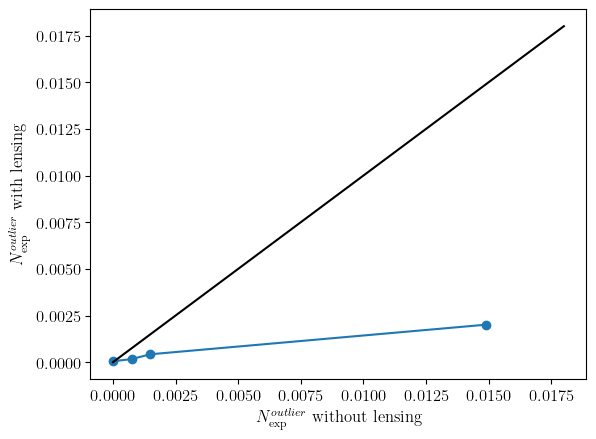

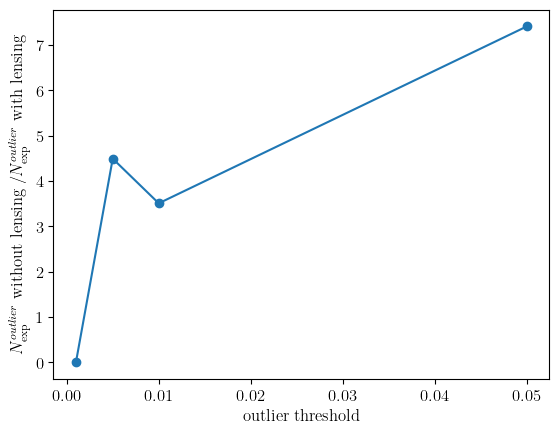

In [48]:
plt.plot(Nexp_lensed_nomag, Nexp_lensed,marker='o')
min = np.min([Nexp_lensed.min(),Nexp_lensed_nomag.min()])
max = np.max([Nexp_lensed.max(),Nexp_lensed_nomag.max()])
plt.plot([min,.018],[min,.018],c='k')
plt.xlabel("$N_{\exp}^{outlier}$ without lensing")
plt.ylabel("$N_{\exp}^{outlier}$ with lensing")
plt.show()

plt.plot(outlier_threshes, Nexp_lensed_nomag/Nexp_lensed,marker='o')
plt.xlabel("outlier threshold")
plt.ylabel("$N_{\exp}^{outlier}$ without lensing $/ N_{\exp}^{outlier}$ with lensing")
plt.show()

# frac_outliers_lensed = np.array([np.sum(ided['magnification']>=2)/len(ided['magnification']) for ided in identified_evs_list])
# frac_outliers_unlensed = np.array([np.sum(ided['magnification']<2)/len(ided['magnification']) for ided in identified_evs_list])
# plt.scatter(frac_outliers_unlensed, frac_outliers_lensed,cmap=outlier_threshes)
# min = np.min([frac_outliers_lensed.min(),frac_outliers_unlensed.min()])
# max = np.max([frac_outliers_lensed.max(),frac_outliers_unlensed.max()])
# plt.plot([min,max],[min,max],c='k')
# plt.xlabel("Fraction of outliers with $\mu<2$")
# plt.ylabel("Fraction of outliers with $\mu\geq2$")
# plt.show()

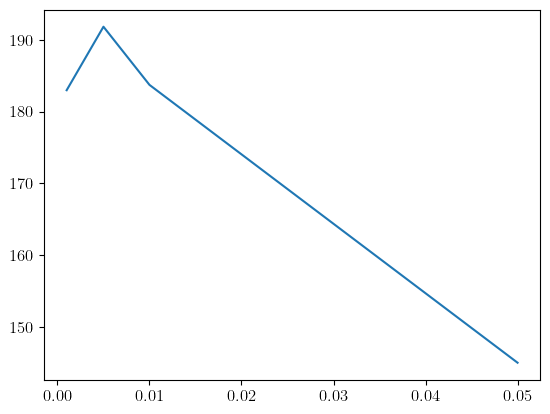

In [12]:
plt.plot(outlier_threshes,m1max_threshs)
plt.show()

### What are the properties of outliers?

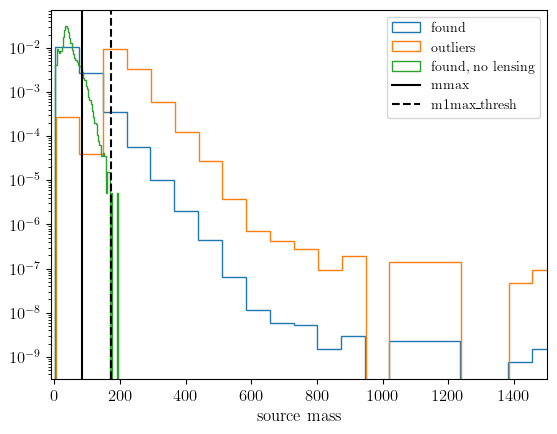

In [103]:
plt.hist(obs_found_evs['inferred_src_mass'],bins=100,density=True,histtype='step',label='found')
plt.hist(identified_evs['inferred_src_mass'],bins=100,density=True,histtype='step',label='outliers')
plt.hist(obs_found_nomag['inferred_src_mass'],bins=50,density=True,histtype='step',label='found, no lensing')
plt.axvline(draw_distribution_params['mmax'],c='k',label='mmax')
plt.axvline(m1max_thresh,c='k',ls="--",label='m1max_thresh')
plt.yscale('log')
plt.xlim(-10,1500)
plt.xlabel('source mass')
plt.legend()
plt.show()

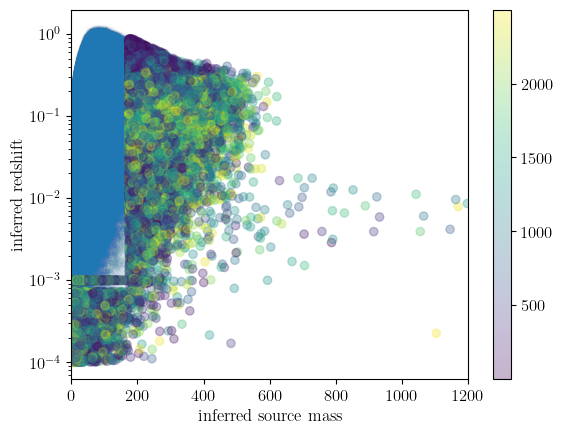

In [104]:
plt.scatter(obs_found_evs['inferred_src_mass'],obs_inferred_redshifts_found,alpha=0.01,marker='.')
plt.scatter(identified_evs['inferred_src_mass'],identified_evs['inferred_redshift'],c=identified_evs['magnification'],alpha=0.3)
plt.colorbar()
plt.ylabel('inferred redshift')
plt.xlabel('inferred source mass')
plt.yscale('log')
plt.xlim(0,1200)
plt.show()

In [100]:
num_dist_outliers = (identified_evs['inferred_distance'] < Dmin_thresh).sum()
num_mass_outliers = (identified_evs['inferred_src_mass'] > m1max_thresh).sum()
num_outliers = len(identified_evs['inferred_redshift'])
print(f"outliers in distance: {num_dist_outliers} ({num_dist_outliers/num_outliers*100}\%)")
print(f"outliers in mass: {num_mass_outliers} ({num_mass_outliers/num_outliers*100}\%)")

outliers in distance: 6952 (2.384774763649337\%)
outliers in mass: 284688 (97.65776149508089\%)


- Is the huge range on the x-axis because of measurement uncertianty? No - seems like its actually magnification!
- should we be looking at the true masses rather than the observed ones?
- am i imagining the band of yellow at redshift 0.1?
- we could plot the fraction of high mag ones in different inferred mass bins, and same for inferred redshift

### Is the Dai interpolant accurate?

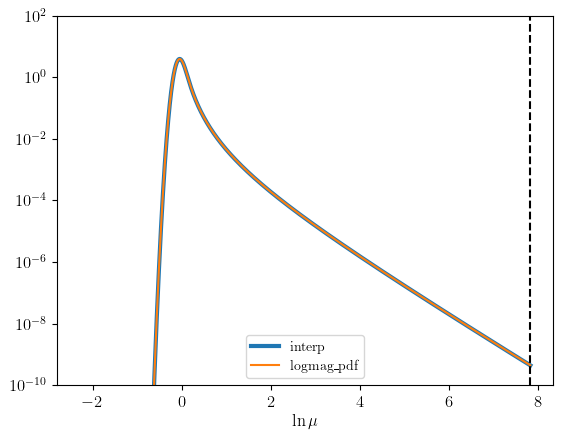

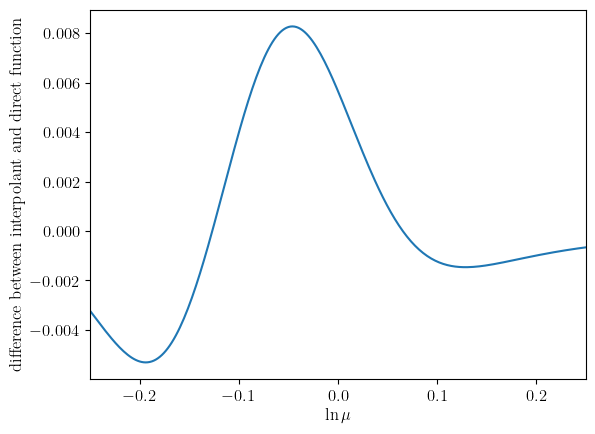

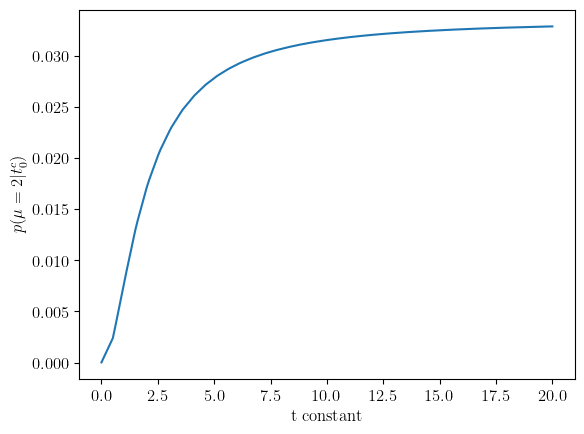

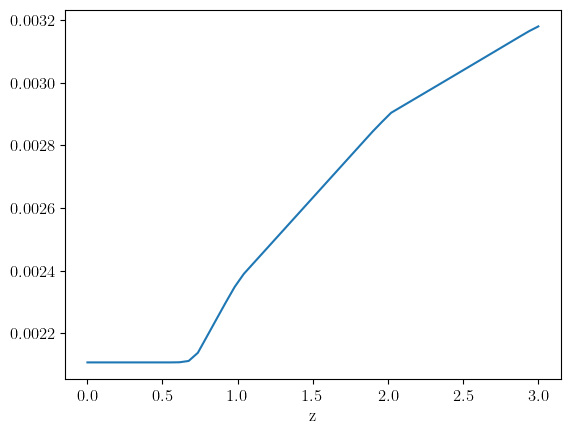

In [52]:
plt.plot(ln_mu_space,mu_interp((ln_mu_space,5,0.0)),label='interp',lw=3)
plt.plot(ln_mu_space,dists.logmag_pdf(ln_mu_space,5),label='logmag_pdf')
plt.axvline(ln_mu_space.max(),color='k',ls='--')
plt.yscale('log')
plt.ylim(1e-10,1e2)
# plt.xlim(-0.25,0.25)
plt.xlabel("$\ln \mu$")
plt.legend()
plt.show()

plt.plot(ln_mu_space,mu_interp((ln_mu_space,5,0.0))-dists.logmag_pdf(ln_mu_space,5))
plt.xlim(-0.25,0.25)
plt.ylabel('difference between interpolant and direct function')
plt.xlabel("$\ln \mu$")
plt.show()

t_dummy = np.linspace(0,20,num=200)
plt.plot(t_dummy,mu_interp((2,1,t_dummy)))
plt.xlabel("t constant")
plt.ylabel("$p(\mu=2|t_0^c)$")
plt.show()

plt.plot(np.linspace(0.001,3),mu_interp((2,np.linspace(0.001,3),0.5)))
plt.xlabel("z")
plt.show()

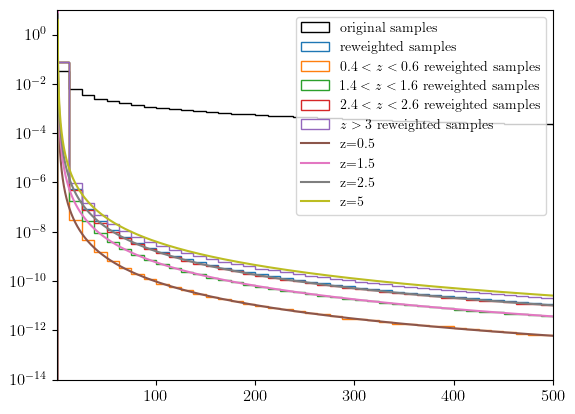

In [22]:
# does using the interpolant weights resemble the original distribution?
mags = injections['magnification']
logmags = np.log(mags)
true_redshifts = injections['true_redshift']
weights = mu_interp((logmags,true_redshifts,0.0))/injections['lnmu_pdraw']

plt.hist(mags,bins=200,density=True,histtype='step',color='k',label='original samples')
plt.hist(mags,bins=200,density=True,weights=weights,histtype='step',label='reweighted samples')
plt.hist(mags[(true_redshifts>=0.48) * (true_redshifts<0.52)],bins=200,density=True,weights=weights[(true_redshifts>=0.48) * (true_redshifts<0.52)],histtype='step',label='$0.4<z<0.6$ reweighted samples')
plt.hist(mags[(true_redshifts>=1.48) * (true_redshifts<1.52)],bins=200,density=True,weights=weights[(true_redshifts>=1.48) * (true_redshifts<1.52)],histtype='step',label='$1.4<z<1.6$ reweighted samples')
plt.hist(mags[(true_redshifts>=2.48) * (true_redshifts<2.52)],bins=200,density=True,weights=weights[(true_redshifts>=2.48) * (true_redshifts<2.52)],histtype='step',label='$2.4<z<2.6$ reweighted samples')
plt.hist(mags[true_redshifts>=3],bins=200,density=True,weights=weights[true_redshifts>=3],histtype='step',label='$z>3$ reweighted samples')

mu_arr = np.exp(ln_mu_space)
plt.plot(mu_arr,dists.logmag_pdf(ln_mu_space,0.5)/mu_arr,label='z=0.5')
plt.plot(mu_arr,dists.logmag_pdf(ln_mu_space,1.5)/mu_arr,label='z=1.5')
plt.plot(mu_arr,dists.logmag_pdf(ln_mu_space,2.5)/mu_arr,label='z=2.5')
plt.plot(mu_arr,dists.logmag_pdf(ln_mu_space,5)/mu_arr,label='z=5')
plt.yscale('log')
plt.xlim(0.3,500)
plt.ylim(1e-14,1e1)
plt.legend(loc='upper right')
plt.show()
# it does!

### Convergence tests for Nexp
- do we have enough effective samples?
- are we railing against high true redshifts or high magnifications in our detected sample? Seems like we are doing that for both, but z=10 is crazy high! And so is mu=2.5k. Not sure what to do.

#### Effective samples

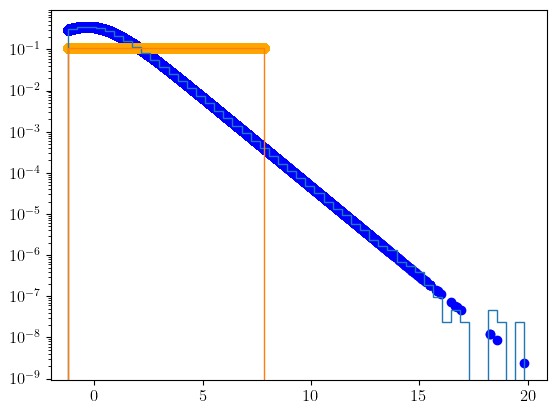

In [33]:
o = injections['magnification']
logmu_pdraw_o = injections['lnmu_pdraw']
s = np_rng.pareto(a=1,size=Ninj)+0.3
s = stats.pareto(1,loc=-0.7).rvs(size=Ninj)
mu_pdraw = stats.pareto(1,loc=-0.7).pdf(s)
# norm = 1/np.log(mu_bounds[0]) - 1/np.log(mu_bounds[1])
# norm = (0.3**2)*2
# mu_pdraw = s**(-2) * norm
logmu_pdraw = mu_pdraw * s
# logmu_pdraw[s<1] = -np.log(s[s<1])
plt.hist(np.log(s),bins=50,density=True,histtype='step')
plt.scatter(np.log(s),logmu_pdraw,color='b')
plt.hist(np.log(o),bins=50,density=True,histtype='step')
plt.scatter(np.log(o),logmu_pdraw_o,color='orange')
# dummy = np.linspace(0.3,15)
# plt.plot(dummy,norm*dummy**-3,label='-3')
# plt.plot(dummy,(1/3)*dummy**-2,label='-2')
# plt.legend()
plt.xlim(left=-2)
plt.yscale('log')

In [18]:
 (found_weights.sum()/Ninj)**2/(np.sum(found_weights**2) / Ninj**2), (np.sum(identified_weights)/Ninj)**2/(np.sum(identified_weights**2) / Ninj**2)

(60.46690913718156, 156.73614312771406)

In [10]:
np.sum(found_weights**2) / Ninj**2 , np.sum(identified_weights**2) / Ninj**2

(5.789327516824706e-09, 1.6650730488223959e-19)

In [31]:
def effective_samples(injs,obs_found=None, identified=None,t0c=0.0):
    mags = injs['magnification']
    logmags = np.log(mags)
    true_redshifts = injs['true_redshift']
    weights = mu_interp((logmags,true_redshifts,t0c))/injs['lnmu_pdraw']
    n_inj = injs['num_injections']
    if obs_found is None or identified is None:
        obs_found, identified = af.find_injections(np_rng,injs,m1max_thresh,Dmin_thresh,osnr,dist_unit,
                                                   O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
    found_weights = weights[obs_found['found_bool']]
    identified_weights = found_weights[identified['identified_bool']]

    efficiency_found = np.sum(found_weights) / n_inj
    variance_found = np.sum(found_weights**2) / n_inj**2 - efficiency_found**2 / n_inj
    Neff_found = efficiency_found**2/variance_found 

    identified_weights = found_weights[identified['identified_bool']]

    efficiency_identified = np.sum(identified_weights) / n_inj
    variance_identified = np.sum(identified_weights**2) / n_inj**2 - efficiency_identified**2 / n_inj
    Neff_identified = efficiency_identified**2/variance_identified 

    return Neff_found, Neff_identified
    

In [32]:
effective_samples(injections)

18368538 found injections
298384 injections found and identified as outliers


(552.7025349313268, 163.44433945580766)

In [35]:
diff_injs = injections
s = np.where(s>2500,2500,s)
diff_injs['magnification'] = s
diff_injs['lnmu_pdraw'] = logmu_pdraw
inferred_distances, inferred_redshifts, inferred_src_masses = trans.inferred_quantities_from_lensing(s, diff_injs['det_mass'], diff_injs['true_distance'])
diff_injs['inferred_distance'] = inferred_distances
diff_injs['inferred_redshift'] = inferred_redshifts
diff_injs['inferred_src_mass'] = inferred_src_masses

effective_samples(diff_injs)

891824 found injections
8307 injections found and identified as outliers


(1632.90747090311, 14.62852813761438)

In [33]:
mags = injections['magnification']
logmags = np.log(mags)
true_redshifts = injections['true_redshift']
weights = mu_interp((logmags,true_redshifts,0.0))/injections['lnmu_pdraw']

# obs_found_evs, identified_evs = af.find_injections(np_rng,injections,m1max_thresh,Dmin_thresh,osnr,dist_unit,
#                                                    O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)

found_bool = obs_found_evs['found_bool']
identified_bool = identified_evs['identified_bool']
found_weights = weights[found_bool]
identified_weights = found_weights[identified_bool]

efficiency = np.sum(found_weights) / Ninj
variance = np.sum(found_weights**2) / Ninj**2 - efficiency**2 / Ninj
Neff_found = efficiency**2/variance 

efficiency = np.sum(identified_weights) / Ninj
variance = np.sum(identified_weights**2) / Ninj**2 - efficiency**2 / Ninj
Neff_identified = efficiency**2/variance 

Neff_found, Neff_identified
# with log-uniform dist: (527.2497930273993, 7.899523113474316)
# (60.46727476410245, 156.73859978807508)

NameError: name 'obs_found_evs' is not defined

In [15]:
diff_injs = injections
s = np.where(s>2500,2500,s)
diff_injs['magnification'] = s
diff_injs['lnmu_pdraw'] = logmu_pdraw

mags_diff = diff_injs['magnification']
logmags_diff = np.log(mags_diff)
true_redshifts = diff_injs['true_redshift']
weights = mu_interp((logmags_diff,true_redshifts,0.0))/diff_injs['lnmu_pdraw']

obs_found_evs_diff, identified_evs_diff = af.find_injections(np_rng,diff_injs,m1max_thresh,Dmin_thresh,osnr,dist_unit,
                                                             O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)

found_bool_diff = obs_found_evs_diff['found_bool']
identified_bool_diff = identified_evs_diff['identified_bool']
found_weights_diff = weights[found_bool_diff]
identified_weights_diff = found_weights_diff[identified_bool_diff]

efficiency = np.sum(found_weights_diff) / Ninj
variance = np.sum(found_weights_diff**2) / Ninj**2 - efficiency**2 / Ninj
Neff_found = efficiency**2/variance 

efficiency = np.sum(identified_weights_diff) / Ninj
variance = np.sum(identified_weights_diff**2) / Ninj**2 - efficiency**2 / Ninj
Neff_identified = efficiency**2/variance 

Neff_found, Neff_identified
# with pareto dist: (127134.64909531552, 7400.752436495615)

1835401 found injections
25117 injections found and identified as outliers


(105905.73575270199, 2522.687136296109)

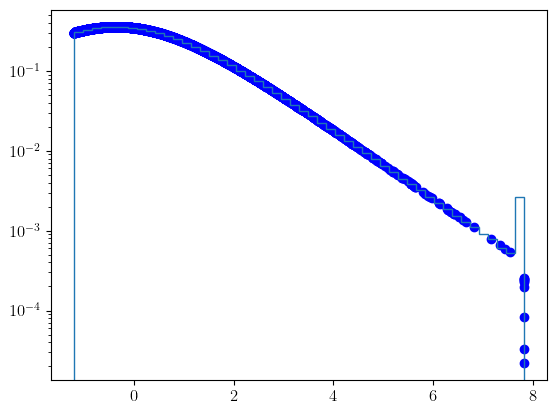

In [17]:
plt.hist(np.log(s),bins=50,density=True,histtype='step')
plt.scatter(np.log(s[:10000]),logmu_pdraw[:10000],color='b')
plt.yscale('log')

#### found injections at the limits of the draw distribution
The first cell shows the problem. The second cell shows its probably not a big problem, as Nexp_lensed is mostly contributed to by $\mu<500$, and not much by $\mu>1500$, for all ranges of t0c. I'm assuming its not a problem for redshift either as high-z and high-mu samples are probably the same samples. 

So basically we don't need to change `MU_MAX` or `ZMAX`

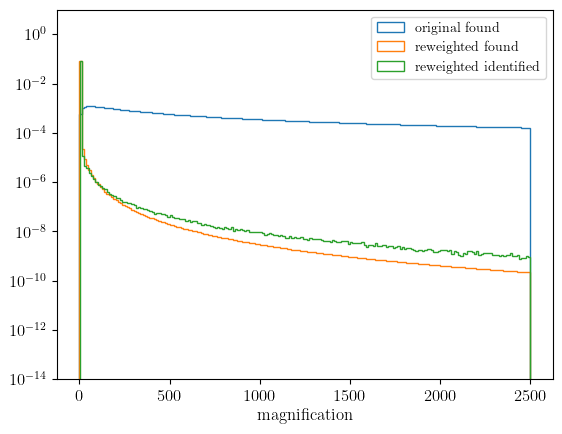

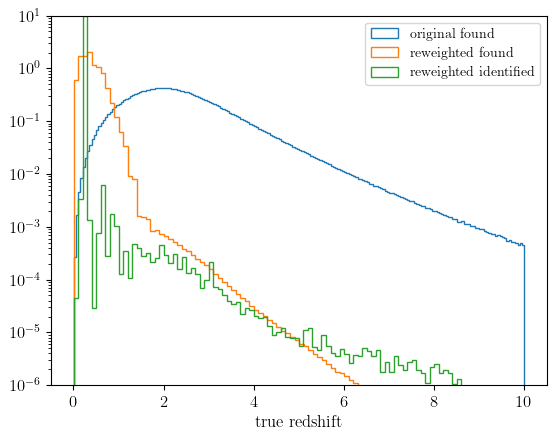

In [24]:
# railing against high mags?
plt.hist(mags_found,bins=200,density=True,histtype='step',label='original found')
plt.hist(mags_found,bins=200,density=True,histtype='step',weights=found_weights,label='reweighted found')
plt.hist(mags_identified,bins=200,density=True,histtype='step',weights=identified_weights,label='reweighted identified')
plt.yscale('log')
# plt.xlim(0.3,500)
plt.ylim(1e-14,1e1)
plt.legend(loc='upper right')
plt.xlabel('magnification')
plt.show()

# railing against high zs?
plt.hist(true_redshifts_found,bins=200,density=True,histtype='step',label='original found')
plt.hist(true_redshifts_found,bins=100,density=True,histtype='step',weights=found_weights,label='reweighted found')
plt.hist(true_redshifts_found[identified_evs['identified_bool']],bins=100,density=True,histtype='step',weights=identified_weights,label='reweighted identified')
plt.yscale('log')
plt.ylim(1e-6,1e1)
plt.legend()
plt.xlabel('true redshift')
plt.show()


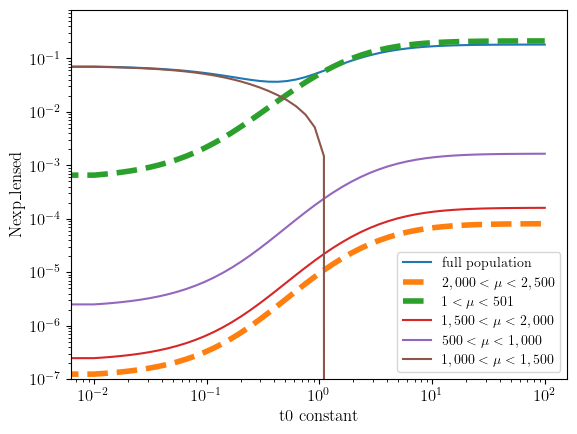

In [51]:
# how much do the high-mu samples contribute to Nexp_lensing?
def nexp_chunks(i):
    return af.calc_Nexp(obs_found_evs, identified_evs_chunk, mu_interp, t_const=t_const_space[i], rate_evo_index=draw_distribution_params['lamb'])

# contribution to Nexp for mu>2k
mag_bool = identified_evs['magnification'] > 2e3
identified_evs_chunk = {key:identified_evs[key][mag_bool] for key in ['det_mass', 'inferred_src_mass', 'mass_ratio', 'inferred_redshift', 'inferred_distance', 'magnification']}
identified_evs_chunk['identified_bool'] = np.logical_and(identified_evs['identified_bool'],obs_found_evs['magnification'] > 2e3)

placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_chunks)(i) for i in range(len(t_const_space))))
Nexp_lensed_gtr_2k = placeholder[:,0]

# contribution for mu<500
mag_bool = np.logical_and(identified_evs['magnification'] < 501, identified_evs['magnification'] > 1)
identified_evs_chunk = {key:identified_evs[key][mag_bool] for key in ['det_mass', 'inferred_src_mass', 'mass_ratio', 'inferred_redshift', 'inferred_distance', 'magnification']}
identified_evs_chunk['identified_bool'] = np.logical_and(identified_evs['identified_bool'],
                                                         np.logical_and(obs_found_evs['magnification'] < 501, obs_found_evs['magnification'] > 1))

placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_chunks)(i) for i in range(len(t_const_space))))
Nexp_lensed_less_500 = placeholder[:,0]

# contribution for 1.5k<mu<2k
mag_bool = np.logical_and(identified_evs['magnification'] < 2e3, identified_evs['magnification'] > 1500)
identified_evs_chunk = {key:identified_evs[key][mag_bool] for key in ['det_mass', 'inferred_src_mass', 'mass_ratio', 'inferred_redshift', 'inferred_distance', 'magnification']}
identified_evs_chunk['identified_bool'] = np.logical_and(identified_evs['identified_bool'],
                                                         np.logical_and(obs_found_evs['magnification'] < 2e3, obs_found_evs['magnification'] > 1500))

placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_chunks)(i) for i in range(len(t_const_space))))
Nexp_lensed_15k_2k = placeholder[:,0]

# contrirbution for 500<mu<1000
mag_bool = np.logical_and(identified_evs['magnification'] > 501, identified_evs['magnification'] < 1000)
identified_evs_chunk = {key:identified_evs[key][mag_bool] for key in ['det_mass', 'inferred_src_mass', 'mass_ratio', 'inferred_redshift', 'inferred_distance', 'magnification']}
identified_evs_chunk['identified_bool'] = np.logical_and(identified_evs['identified_bool'],
                                                         np.logical_and(obs_found_evs['magnification'] > 501, obs_found_evs['magnification'] < 1000))

placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_chunks)(i) for i in range(len(t_const_space))))
Nexp_lensed_500_1k = placeholder[:,0]

plt.plot(t_const_space,Nexp_lensed_arr,label='full population')
plt.plot(t_const_space,Nexp_lensed_gtr_2k,lw=4,ls='--',label='$2,000<\mu<2,500$')
plt.plot(t_const_space,Nexp_lensed_less_500,lw=4,ls='--',label='$1<\mu<501$')
plt.plot(t_const_space,Nexp_lensed_15k_2k,label='$1,500<\mu<2,000$')
plt.plot(t_const_space,Nexp_lensed_500_1k,label='$500<\mu<1,000$')
plt.plot(t_const_space,Nexp_lensed_1k_15k,label='$1,000<\mu<1,500$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim(bottom=1e-7)
plt.xlabel('t0 constant')
plt.ylabel('Nexp_lensed')
plt.show()

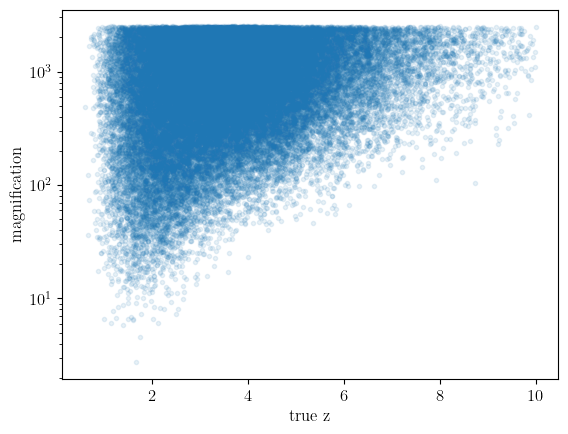

In [31]:
plt.scatter(obs_found_evs['true_redshift'][identified_evs['identified_bool']][:50000],identified_evs['magnification'][:50000],alpha=0.1,marker='.')
plt.xlabel("true z")
plt.ylabel("magnification")
plt.yscale('log')
plt.show()

### $N_{exp}$ sanity check: no lensing case
do we get the right Nexp when magnification doesn't happen? We expect Nexp_traditional=70 (how many events we got in GWTC-3) and Nexp_lensing=OUTLIER_THRESH*2 (the false positive rate, which is how many natural outliers we expect given our definition of an outlier and the fact that we are looking for it in two dimensions)

In [12]:
injections_nomag = injections.copy()
injections_nomag['magnification'] = np.ones_like(injections['magnification'])
injections_nomag['inferred_distance'] = injections_nomag['true_distance']
injections_nomag['inferred_redshift'] = injections_nomag['true_redshift']
injections_nomag['inferred_src_mass'] = injections_nomag['true_src_mass']

In [20]:
l = np.zeros(10)
t = np.zeros(10)
z_dummy = np.linspace(0.001,dists.ZMAX,num=100)
total_rate = 15 * np.trapz(x=z_dummy,y=dists.shouts_murmurs(
    z_dummy,alpha=draw_distribution_params['lamb'],beta=dists.BETA,zp=dists.ZPEAK))
for i in range(10):
    obs_found_nomag, identified_nomag = af.find_injections(np_rng,injections_nomag,m1max_thresh,Dmin_thresh,osnr,dist_unit,
                                                           O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
    
    t[i] = obs_found_nomag['num_found'] * total_rate * O3_OBS_TIME / Ninj

print(t.mean(), t.std())
# expected result: OUTLIER_THRESH*2/100 (0.0002), 70 

5022 found injections
1 injections found and identified as outliers
4988 found injections
1 injections found and identified as outliers
5100 found injections
0 injections found and identified as outliers
5044 found injections
0 injections found and identified as outliers
5073 found injections
0 injections found and identified as outliers
5156 found injections
1 injections found and identified as outliers
5028 found injections
0 injections found and identified as outliers
5090 found injections
0 injections found and identified as outliers
5120 found injections
1 injections found and identified as outliers
5072 found injections
0 injections found and identified as outliers
30.708197620846597 0.28843782205474616


In [111]:
# is the false positive rate driven by dl or m? try dl_thresh=0 here to see the false positive rate just from m
l = np.zeros(20)
t = np.zeros(20)
for i in trange(20):
    obs_found_nomag, identified_nomag = af.find_injections(np_rng,injections_nomag,m1max_thresh,0,osnr,dist_unit,O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
    Ninj = obs_found_nomag['num_generated_total']
    # mags_found = obs_found_nomag['magnification']
    # true_redshifts = obs_found_nomag['true_redshift']
    identified = identified_nomag['identified_bool']
    found = obs_found_nomag['found_bool']

    z_dummy = np.linspace(0.001,dists.ZMAX,num=100)
    total_rate = 15 * np.trapz(x=z_dummy,y=dists.shouts_murmurs(
        z_dummy,alpha=draw_distribution_params['lamb'],beta=dists.BETA,zp=dists.ZPEAK))

    l[i] = identified.sum() * total_rate * 1 / Ninj
    t[i] = found.sum() * total_rate * 1 / Ninj

print(l.mean(), l.std())

  0%|          | 0/20 [00:00<?, ?it/s]

50352 found injections


  5%|▌         | 1/20 [00:56<17:52, 56.44s/it]

3 injections found and identified as outliers
50479 found injections


 10%|█         | 2/20 [01:52<16:56, 56.49s/it]

4 injections found and identified as outliers
50439 found injections


 15%|█▌        | 3/20 [02:50<16:07, 56.91s/it]

4 injections found and identified as outliers
50349 found injections


 20%|██        | 4/20 [03:47<15:09, 56.84s/it]

2 injections found and identified as outliers
50499 found injections
1 injections found and identified as outliers


 25%|██▌       | 5/20 [06:11<22:03, 88.24s/it]

50537 found injections


 30%|███       | 6/20 [08:04<22:36, 96.87s/it]

2 injections found and identified as outliers
50327 found injections


 35%|███▌      | 7/20 [09:00<18:05, 83.50s/it]

2 injections found and identified as outliers
50489 found injections


 40%|████      | 8/20 [09:56<14:56, 74.69s/it]

4 injections found and identified as outliers
50157 found injections


 45%|████▌     | 9/20 [10:52<12:37, 68.91s/it]

1 injections found and identified as outliers
50461 found injections


 50%|█████     | 10/20 [12:14<12:08, 72.84s/it]

1 injections found and identified as outliers
50621 found injections


 55%|█████▌    | 11/20 [13:11<10:11, 67.98s/it]

3 injections found and identified as outliers
50634 found injections


 60%|██████    | 12/20 [14:08<08:36, 64.58s/it]

0 injections found and identified as outliers
50323 found injections


 65%|██████▌   | 13/20 [15:05<07:17, 62.43s/it]

2 injections found and identified as outliers
50358 found injections


 70%|███████   | 14/20 [16:02<06:04, 60.73s/it]

1 injections found and identified as outliers
50425 found injections


 75%|███████▌  | 15/20 [16:58<04:57, 59.41s/it]

5 injections found and identified as outliers
50305 found injections


 80%|████████  | 16/20 [17:54<03:53, 58.39s/it]

6 injections found and identified as outliers
50531 found injections


 85%|████████▌ | 17/20 [18:50<02:53, 57.71s/it]

2 injections found and identified as outliers
50362 found injections


 90%|█████████ | 18/20 [19:47<01:54, 57.26s/it]

2 injections found and identified as outliers
50466 found injections


 95%|█████████▌| 19/20 [20:42<00:56, 56.85s/it]

3 injections found and identified as outliers
50433 found injections


100%|██████████| 20/20 [21:38<00:00, 64.94s/it]

4 injections found and identified as outliers
0.0019346569971040017 0.0011136651760135508


`Nexp_traditional` is always a little high (more like 80 than 70) - is this a problem? maybe its just the semianalytic selection, or maybe its the different redshift distribution?

### Are PPDs ever insensitive to the number of data points?

100%|██████████| 9/9 [27:48<00:00, 185.34s/it]


Text(0.5, 0, 'mmax')

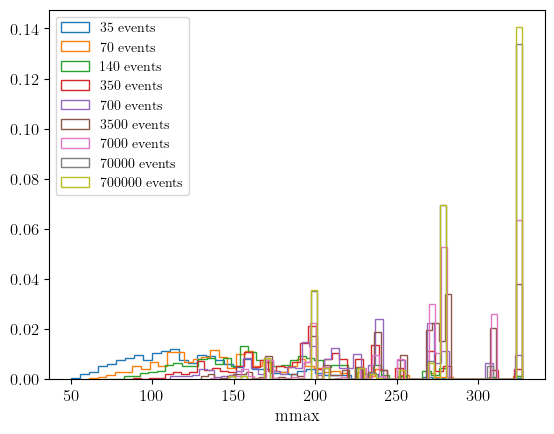

In [100]:
n_evs_arr = np.round(np.array([.5,1,2,5,10,50,1e2,1e3,1e4])*70)
n_evs_arr = np.array(n_evs_arr,dtype=int)
m1max = np.zeros([len(n_evs_arr),n_hyperpe])
for j in trange(len(n_evs_arr)):
    # for each population draw from PLP
    for i, row in tqdm(samples.iterrows(), total=samples.shape[0]): 
        # draw many injections, weighted by this population draw
        expanded_row = row
        expanded_row['delta_m']=characteristic_pop['delta_m']
        p_target = dists.threeDpopulation(true_m1s,true_q,true_z,
                                    m1_kwargs=expanded_row[mass_keys],
                                    q_beta=row['beta'],z_alpha=row['lamb'],normalize=False)

        p_ratio = p_target / obs_pdraw
        idxs = np.random.choice(ndet,size=n_evs_arr[j],replace=True,
                                p=p_ratio/np.sum(p_ratio))
        rwed_m1s = obs_m1s[idxs]

        # find maximum predicted mass
        m1max[j,i] = rwed_m1s.max()
    plt.hist(m1max[j],bins=50,density=True,histtype='step',label=f"{n_evs_arr[j]} events")
plt.legend()
plt.xlabel('mmax')

There is some undersampling going on (seems like there are only 2 injections above 300 solar masses) but regardless, it seems like the extrema always grow with the number of detections. But, do they grow faster than the maximum expected mass from lensing?

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [02:40<00:00, 17.84s/it]


Text(0.5, 0, 'mmax')

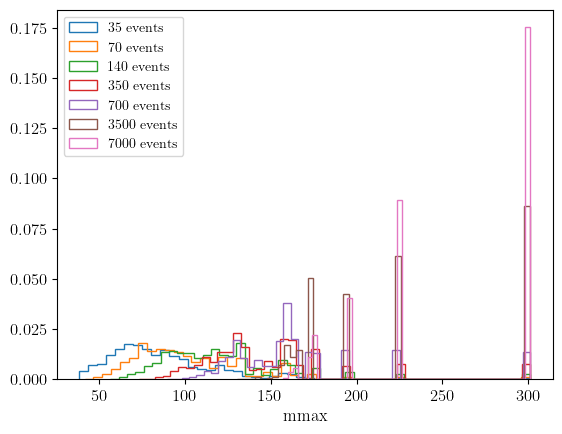

In [107]:
true_distances_found = true_distances[found]

mmax_lensing = np.zeros_like(m1max)
for j in trange(len(n_evs_arr)):
    for i in range(2146):
        idxs = np.random.choice(ndet,size=n_evs_arr[j],replace=True)
        mag_samples = mags_found[idxs]
        # I'm using the true values (not observed/fluctuated) here because I want to only compare magnification to fluctuations
        det_mass_samples = true_det_masses_found[idxs]
        distance_samples = true_distances_found[idxs]
        redshift_samples = trans.z_at_dl_approx(distance_samples)
        src_mass_samples = det_mass_samples / (1 + redshift_samples)
        mmax_lensing[j,i] = src_mass_samples.max()
    if j<7:
        plt.hist(mmax_lensing[j],bins=50,density=True,histtype='step',label=f"{n_evs_arr[j]} events")
    
plt.legend()
plt.xlabel('mmax')

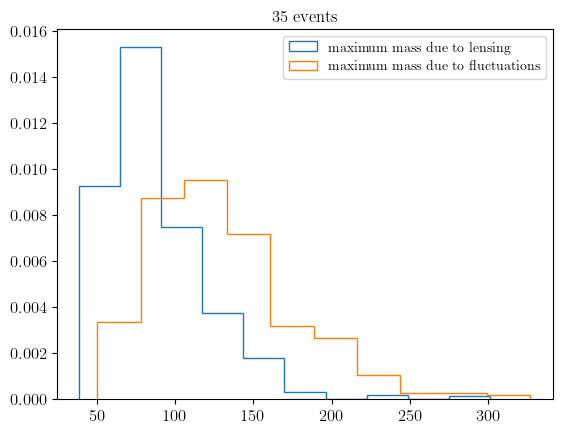

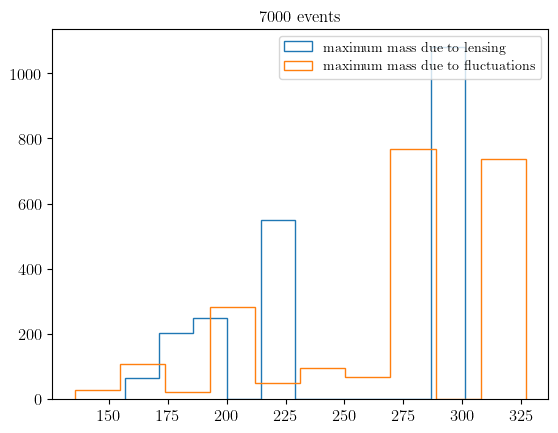

In [115]:
plt.hist(mmax_lensing[0],histtype='step',density=True,label="maximum mass due to lensing")
plt.hist(m1max[0],histtype='step',density=True,label="maximum mass due to fluctuations")
plt.title(f"{n_evs_arr[0]} events")
plt.legend()
plt.show()
plt.hist(mmax_lensing[6],histtype='step',label="maximum mass due to lensing")
plt.hist(m1max[6],histtype='step',label="maximum mass due to fluctuations")
plt.title(f"{n_evs_arr[6]} events")
plt.legend()
plt.show()

It seems like the maximum mass due to magnification will eventually overtake the one due to fluctuations, but its hard to tell right now because of the lack of found injections.

### Playing around with phenomenological magnification distribution models

In [ ]:
from scipy.interpolate import RegularGridInterpolator
import sampling

In [2]:
def lognorm(x,logmean,logsigma):
    norm = x * logsigma * np.sqrt(2*np.pi)
    return np.exp(-(np.log(x) - logmean)**2 / (2 * logsigma**2)) / norm
def dpdmu(mu,z,t0,at,s,sigma):
    mumax = 70000
    mu_plonset = 0.56
    _mu_dummy = np.linspace(1.001,mumax)
    plnorm = np.trapz(x=_mu_dummy,y= dists.smoothing(_mu_dummy,mu_plonset,mumax,s) * dists.powerlaw(_mu_dummy-1,-3,mumax,mu_plonset-1))
    return ( 1 - t0 ) * lognorm(mu,0.,sigma) + t0 * dists.powerlaw(mu-1,-3,mumax,mu_plonset-1) * dists.smoothing(mu,mu_plonset,mumax,s) * plnorm

def high_tail(mu):
    return (mu-1)**-3

def draw_from_shitty(rng,nsamps,S_gtr_mup,mup=3,return_pdraw=False):
    # draw from a uniform distribution up to muprime - this will be the bulk of events
    minmu = 0.3
    mu_samps = rng.uniform(minmu,mup,nsamps)
    # some fraction of events (S_gtr_mup) should be drawn from a (1-mu)^-3 tail
    # calculate how many events that is
    n_plaw = int(round(nsamps*S_gtr_mup))
    print(n_plaw)
    # draw them
    maxmu = 5000
    plaw = sampling.inverse_transform_sample(high_tail,[mup,maxmu],rng,n_plaw,num_interp_points=10000)
    # replace some uniform samples with the power law
    mu_samps[:n_plaw] = plaw
    if return_pdraw:
        pdraw = (1-S_gtr_mup)/(mup-minmu) * np.ones_like(mu_samps)
        pdraw[:n_plaw] = S_gtr_mup * high_tail(plaw) / ( 2 * ((mup-1)**(-2) - (maxmu-1)**(-2)) ) 
        return mu_samps, pdraw
    else:
        return mu_samps


tau =  2.8362249248611455e-53
tau =  2.707217578544347e-10
tau =  1.6456136642151285e-05
tau =  0.0017495200368557228
tau =  0.027392955557711575
tau =  0.09398071457654948
tau =  0.37947978182292763


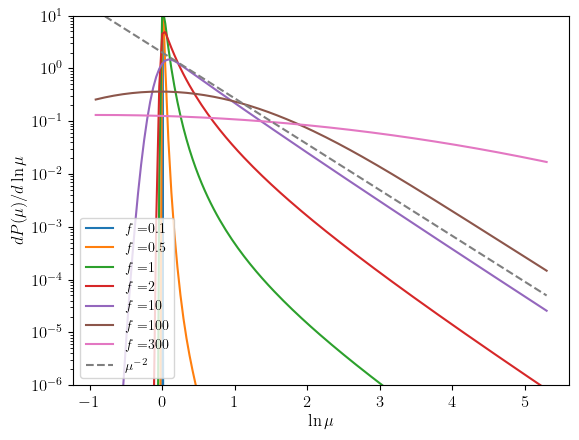

In [154]:
# non-Dai17 models/modifications to that model

# for spectral_index in [0,1,2,10,100]:
#     plt.plot(lnmu_dummy,(mu_dummy**spectral_index)*dists.logmag_pdf_Lambda(lnmu_dummy,sigma=0.01,t0=1,delta=-np.log(1.0465)), label=f"alpha={spectral_index}")
# for t0 in [0.01,0.356,1,2,10,1e6]:
#     plt.plot(TEST_LNMU,dists.logmag_pdf_Lambda(TEST_LNMU,sigma=0.01,t0=t0,delta=-np.log(1.0465)), label=f"$t_0=${t0}")
# for sigma in np.array([0.008,0.010,0.028,0.050,0.078,0.110,0.150,1]):
#     plt.plot(TEST_LNMU,dists.logmag_pdf_Lambda(TEST_LNMU,sigma=sigma,t0=1e3,delta=-np.log(1.0465)), label=f"$\sigma=${sigma}")
# for sig in [0.1,1,2,10,20,100]:
#     norm = np.trapz(x=mu_dummy,y=stats.lognorm.pdf(sig,mu_dummy)/mu_dummy)
#     plt.plot(lnmu_dummy,stats.lognorm.pdf(sig,mu_dummy)/mu_dummy/norm,label=f'$\sigma={sig}$')   
# for l in [1e-10,0.1,1,3,5,10]:
#     plt.plot(TEST_LNMU,dists.logmag_pdf_Lambda(TEST_LNMU,sigma=0.01,t0=0.356,delta=-np.log(1.0465),lam=l), label=f"$\lambda={l}$") 

def logmag_pdf_universal_factor(logmu,z,factor):
    """Magnification distribution from Dai et al. 2017 with additive constant to t0"""
    sigma=np.interp(z,dists.z_vals,dists.sigma_vals) * factor
    t0=np.interp(z,dists.z_vals,dists.t0_vals) * factor
    delta=np.interp(z,dists.z_vals,dists.delta_vals) * factor/10
    lam=5
    
    A = 1./dists._invA(t0,lam)
    
    p = np.zeros_like(logmu)
    for i in range(len(p)):
        p[i] = np.trapz(y=np.exp(lam/(dists.t_arr+t0)-2*dists.t_arr)*np.exp(-(logmu[i] - delta - dists.t_arr)**2/(2*sigma**2)),
                    x=dists.t_arr) * A / np.sqrt(2*np.pi) / sigma
    return p
    
lnmu_dummy = np.linspace(np.log(muprime),np.log(dists.MU_MAX),num=int(-(np.log(muprime)-np.log(dists.MU_MAX))/dlogmu))
lnmu_for_norm = np.linspace(np.log(0.3),np.log(dists.MU_MAX),num=int(-(np.log(0.3)-np.log(dists.MU_MAX))/dlogmu))
muprime=5
dlogmu=0.01
reference_z=0.7
for f in [0.1,0.5,1,2,10,100,300]:
    plt.plot(TEST_LNMU,logmag_pdf_universal_factor(TEST_LNMU,z=1,factor=f), label=f"$f=${f}")
    print("tau = ",
           np.trapz(x=lnmu_dummy,
                    y=logmag_pdf_universal_factor(lnmu_dummy,z=1,factor=f)/np.trapz(x=lnmu_for_norm,
                                                                                    y=logmag_pdf_universal_factor(lnmu_for_norm,z=1,factor=f)))
    )
plt.plot(TEST_LNMU,TEST_MU**(-2)*2,ls="--",label="$\mu^{-2}$")
plt.legend()
plt.yscale("log")
plt.xlabel('$\ln \mu$')
plt.ylabel('$dP(\mu)/d\ln \mu$')
plt.ylim(bottom=1e-6,top=1e1)
plt.show()

In [137]:
factor_space = np.array([0.1,0.5,1,1.5,2,5,10,50,100,200])
pdf_grid = np.zeros((len(ln_mu_space),len(z_space),len(factor_space)))

for j in trange(len(z_space)):
    for k in range(len(factor_space)):
        pdf_grid[:,j,k] = logmag_pdf_universal_factor(ln_mu_space,z_space[j],factor_space[k])

100%|██████████| 100/100 [52:42<00:00, 31.62s/it]  


calculating tau


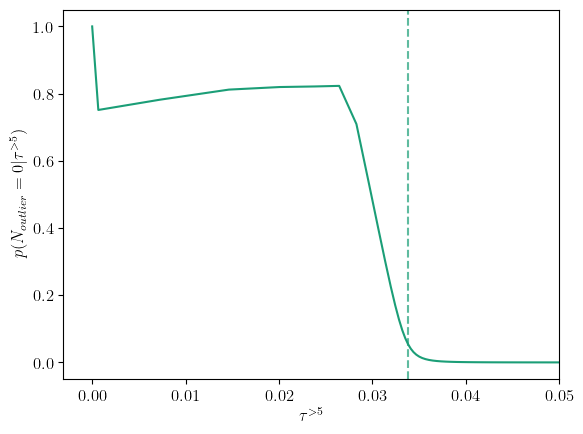

95th percentile of p(tau): 0.03380834387324469


In [151]:
mu_interp = RegularGridInterpolator((ln_mu_space,z_space,factor_space),pdf_grid)
factor_arr = np.linspace(0.1,75)
Nexp_lensed_arr = np.zeros_like(factor_arr)
Nexp_traditional_arr = np.zeros_like(factor_arr)
def nexp_parallel(i):
    return af.calc_Nexp(obs_found_evs, identified_evs, mu_interp, t_const=factor_arr[i], rate_evo_index=draw_distribution_params['lamb'])
plchldr = np.array(Parallel(n_jobs=-1)(delayed(nexp_parallel)(i) for i in range(len(factor_arr))))
Nexp_lensed_arr, Nexp_traditional_arr = plchldr[:,0], plchldr[:,1]

# calculate the optical depth, tau, of magnifications greater than muprime at z=reference_redshift, as a function of t0c
muprime = 5
reference_redshift = 1
tau_arr = np.zeros_like(factor_arr)
print("calculating tau")
lnmu_dummy = np.linspace(np.log(muprime),np.log(dists.MU_MAX),num=int(-(np.log(muprime)-np.log(dists.MU_MAX))/dlogmu))
lnmu_for_norm = np.linspace(np.log(0.3),np.log(dists.MU_MAX),num=int(-(np.log(0.3)-np.log(dists.MU_MAX))/dlogmu))
for i, f in enumerate(factor_arr):
    tau_arr[i] = np.trapz(x=lnmu_dummy,
                    y=logmag_pdf_universal_factor(lnmu_dummy,z=1,factor=f)/np.trapz(x=lnmu_for_norm,
                                                                                    y=logmag_pdf_universal_factor(lnmu_for_norm,z=1,factor=f)))

# plug Nexp into the poisson likelihood, but plot it as a function of tau
percentile=95
plt.plot(tau_arr,stats.poisson(Nexp_lensed_arr).pmf(0),color=color_lensing_dark)
cdf = cumtrapz(x=Nexp_lensed_arr,y=stats.poisson(Nexp_lensed_arr).pmf(0), initial=0)
percentile_idx = np.argmin(np.abs(cdf/cdf[-1]-percentile/100))
plt.axvline(tau_arr[percentile_idx],ls='--',alpha=0.7,color=color_lensing_dark)
plt.xlabel('$\\tau^{>5}$')
plt.ylabel('$p(N_{outlier}=0|\\tau^{>5})$')
plt.xlim(right=0.05)
plt.show()

print(f"{percentile}th percentile of p(tau): {tau_arr[percentile_idx]}")

In [7]:
t_const_space.shape

(53,)

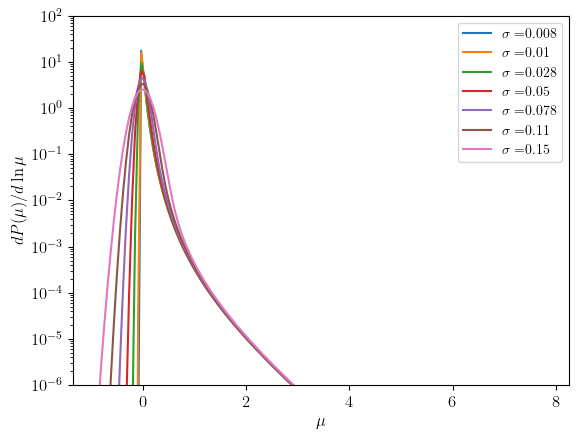

/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/lensing_populations/dists.py:170: RuntimeWarning: overflow encountered in exp
  A = 1./np.trapz(y=np.exp(lam/(tgrid+t0grid)-2*tgrid),x=tgrid,axis=1)
/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/lensing_populations/dists.py:171: RuntimeWarning: overflow encountered in exp
  p = np.trapz(y=np.exp(lam/(tgrid+t0grid)-2*tgrid)*np.exp(-(logmugrid - deltagrid - tgrid)**2/(2*sigmagrid**2)),
/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/lensing_populations/dists.py:171: RuntimeWarning: invalid value encountered in multiply
  p = np.trapz(y=np.exp(lam/(tgrid+t0grid)-2*tgrid)*np.exp(-(logmugrid - deltagrid - tgrid)**2/(2*sigmagrid**2)),
/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/lensing_populations/dists.py:170: RuntimeWarning: divide by zero encountered in divide
  A = 1./np.trapz(y=np.exp(lam/(tgrid+t0grid)-2*tgrid),x=tgrid,axis=1)
/Users/

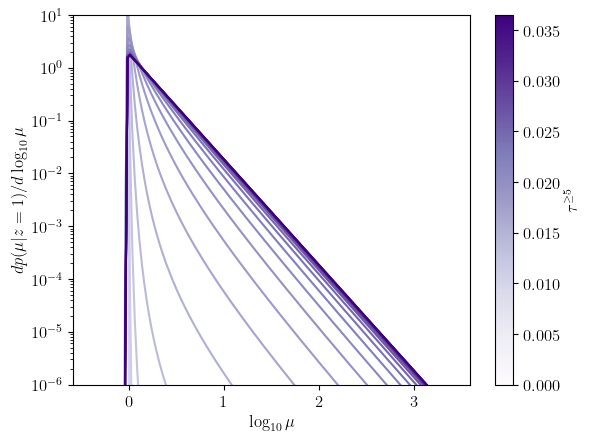

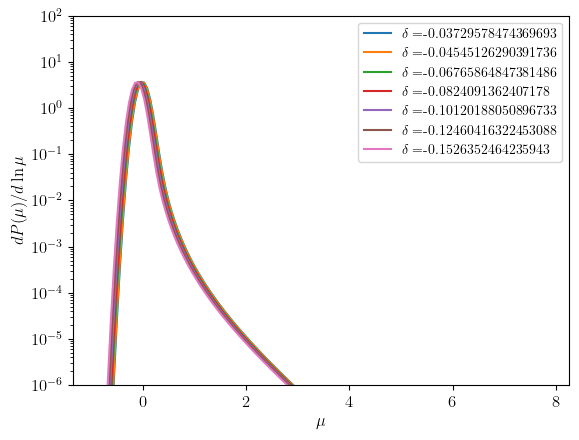

In [25]:
# changing parameters in Dai+17
for sigma in np.array([0.008,0.010,0.028,0.050,0.078,0.110,0.150]):
    plt.plot(TEST_LNMU,dists.logmag_pdf_Lambda(TEST_LNMU,sigma=sigma,t0=0.39,delta=-np.log(1.0465)), label=f"$\sigma=${sigma}")
plt.legend()
plt.yscale("log")
plt.xlabel('$\mu$')
plt.ylabel('$dP(\mu)/d\ln \mu$')
plt.ylim(bottom=1e-6,top=1e2)
plt.show()

t0c_downsampled = t_const_space[::2]
n_lines = len(t0c_downsampled)
cmap = plt.colormaps['Purples']
from matplotlib import colors
norm = colors.Normalize(vmin=tau_arr.min(),vmax=tau_arr.max())

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))
f,ax = plt.subplots()
for i in range(n_lines): #(dists.t0_vals[1] + t_const_space[:10]): #[0.01,0.365,0.399,0.471,0.511,0.557,0.609,0.666,1,2]:
    c= colors[i]
    t0c=t0c_downsampled[i]
    s = ax.plot(np.log10(TEST_MU),dists.logmag_pdf_Lambda(TEST_LNMU,sigma=0.01,t0=t0c,delta=-np.log(1.0465)), color=c)

f.colorbar(plt.cm.ScalarMappable(cmap=cmap,norm=norm), ax=ax, label='$\\tau^{\geq 5}$')
plt.yscale("log")
plt.xlabel('$\log_{10}\mu$')
plt.ylabel('$dp(\mu|z=1)/d\log_{10} \mu$')
plt.ylim(bottom=1e-6,top=1e1)
plt.show()

for delta in -np.log([1.0380,1.0465,1.0700,1.0859,1.1065,1.1327,1.1649]):
    plt.plot(TEST_LNMU,dists.logmag_pdf_Lambda(TEST_LNMU,sigma=0.1,t0=0.39,delta=delta), label=f"$\delta=${delta}")
plt.legend()
plt.yscale("log")
plt.xlabel('$\mu$')
plt.ylabel('$dP(\mu)/d\ln \mu$')
plt.ylim(bottom=1e-6,top=1e2)
plt.show()

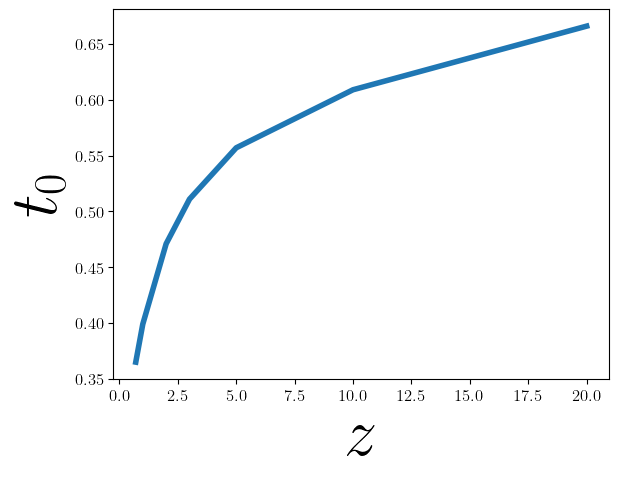

In [50]:
plt.plot(dists.z_vals,dists.t0_vals,lw=4)
plt.xlabel('$z$',fontsize=48)
plt.ylabel('$t_0$',fontsize=48)
plt.show()

In [ ]:
# lognorm + PL mixture model test
mu_dummy = TEST_MU #np.linspace(.001,200,num=500)
plt.plot(mu_dummy,dpdmu(mu_dummy,z=1,t0=0,at=2.8,s=3,sigma=.1))
plt.plot(mu_dummy,dpdmu(mu_dummy,z=1,t0=1,at=2.8,s=3,sigma=.1))
plt.plot(mu_dummy,dpdmu(mu_dummy,z=1,t0=0.5,at=2.8,s=3,sigma=.1))
plt.plot(mu_dummy,dpdmu(mu_dummy,z=1,t0=0.99999,at=2.8,s=3,sigma=.1))
# TODO:try lognorm
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-14,20)
plt.show()

# Old code

In [ ]:
import sampling

### Direct samping from $p(\mu|z)$

#### SIS

In [67]:
Ninj = int(5e7)
src_masses, det_masses, q, true_redshifts, true_distances, thetas, pdraw = rates.draw_true(characteristic_pop,Ninj,np_rng,z_bounds=[0.001,ZMAX],mass_bounds=[1,500.])
thetas = draw_thetas(rng=np_rng,N=Ninj)
# mags = np_rng.uniform(low=1,high=1000.,size=Ninj)
# mags = np_rng.pareto(2,size=Ninj)
mags=np.zeros(Ninj)
for i in trange(Ninj):
        mags[i] = sampling.inverse_transform_sample(dists.dtau_dmu_generic,[0.3,7000],num_interp_points=int(1e4),
                                                    rng=np_rng,N=1,t=dists.dtau_dmu_sis(true_redshifts[i])
                                                   )

inferred_distances, inferred_redshifts, inferred_src_masses = trans.inferred_quantities_from_lensing(mags, det_masses, true_distances)


100%|██████████| 50000000/50000000 [9:02:57<00:00, 1534.81it/s]    


#### Dai et al interpolant

In [ ]:
from scipy.integrate import cumtrapz
mags=np.zeros(Ninj)
for i in trange(Ninj):
        p_of_lnmu = mu_interp((TEST_LNMU,true_redshifts[i],0.))
        cdf = cumtrapz(p_of_lnmu,TEST_LNMU,initial=0)
        cdf /= cdf[-1]
        r = np_rng.uniform()
        mags[i] = np.interp(r,cdf,TEST_MU)
inferred_distances, inferred_redshifts, inferred_src_masses = trans.inferred_quantities_from_lensing(mags, det_masses, true_distances)

### $p(\mu>\mu_{\min}|\det,\theta)$

In [29]:
# What was the probablility of observing this magnification given the event was detected *with these specific source parameters*?
# this is fraction of found injections with mu>min_mu_outlier (injections have same observed parameters as event,
# with mu drawn from Dai mag dist.
# THIS IS ALWAYS EQUAL TO P(mu>=mu_min) since Pdet=1 for the detected event. 
num_gen = int(1e5)
logmags_inj, logmu_pdraw_injs = np_rng.uniform(np.log(0.3),np.log(dists.MU_MAX),size=num_gen), np.ones(num_gen)/(np.log(dists.MU_MAX)-np.log(0.3))
mags_inj = np.exp(logmags_inj)
injs = dict(
    magnification = mags_inj,
    lnmu_pdraw = logmu_pdraw_injs,
    mass_ratio = np.full(num_gen,outlier_maxl['mass_ratio']),
    det_mass = np.full(num_gen,outlier_maxl['det_mass']),
    inferred_redshift = np.full(num_gen,outlier_maxl['inferred_redshift']),
    true_redshift = trans.z_at_dl_approx(outlier_maxl['inferred_distance']*np.sqrt(mags_inj)),
    inferred_src_mass = np.full(num_gen,outlier_maxl['inferred_src_mass']),
    num_injections = num_gen
    )

found_injs, ided_injs = af.find_injections(np_rng,injs,m1max_thresh,Dmin_thresh,osnr,dist_unit,O3_MEASUREMENT_UNCERTAINTY,GWMOCKCAT_COSMO_DICT)
weights_det = mu_interp((np.log(found_injs['magnification']),found_injs['true_redshift'],0.)) /found_injs['lnmu_pdraw']
p_mu_given_det_theta = np.sum(weights_det[found_injs['magnification']>=min_mu_outlier])/weights_det.sum()
print(f"The probability of getting an event with mu>={min_mu_outlier:.1f} given the detected distribution"
      f"of magnifications and this event's source parameters is {p_mu_given_det_theta:.5f}")

54695 found injections
35974 injections found and identified as outliers


ValueError: One of the requested xi is out of bounds in dimension 1